# Modules

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ast
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import re
from labellines import labelLine, labelLines
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import truncnorm

from pysynphot import observation
from pysynphot import spectrum

import seaborn as sns
plt.style.use('default')

/Users/joel/anaconda3/lib/python3.11/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/joel/anaconda3/lib/python3.11/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
print(np.log10(0.03))
print(np.log10(0.08))

-1.5228787452803376
-1.0969100130080565


# Import Multifit Data

In [4]:
# Removes nan values (logl5100 column) to convert string lists to lists
def formatLineParamDataframe(df):
    logl5100 = df.at['Ha_br', 'logl5100'] # Obtain optical continuum values
    logl5100 = list(map(float, ast.literal_eval(logl5100))) # convert string list of strings to list of floats
    df = df.drop('logl5100', axis=1) # remove nan values in this column
    df = df.map(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x) # convert string lists in all cells to lists
    return df, logl5100


# 1 gauss 200 fits with HA HB broad Balmer lines untied for 2022/24 but tied for 04 due to low SNR HB indicating unphysical (double) FWHM as HA
df_04 = pd.read_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/Multi-fit Line Parameters/2004_ngauss1_br_balmer_tied_fits200.csv', index_col=0)
df_04, logL5100_04 = formatLineParamDataframe(df_04) # get line parameters and optical continuum

df_22 = pd.read_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/Multi-fit Line Parameters/2022_ngauss1_br_hbha_untied_fits200.csv', index_col=0)
df_22, logL5100_22 = formatLineParamDataframe(df_22)

df_24 = pd.read_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/Multi-fit Line Parameters/2024_ngauss1_br_hbha_untied_fits200.csv', index_col=0)
df_24, logL5100_24 = formatLineParamDataframe(df_24)


df_04

,fwhm,sigma,ew,peak,area,snr
Ha_br,"[5244.096165255208, 5353.437348032349, 5331.18...","[2197.2159090685686, 2243.0360408130878, 2233....","[144.11036857068672, 142.09119847277344, 149.3...","[6563.573948429277, 6562.525328787629, 6562.22...","[3337.3130729117784, 3278.1055611626507, 3391....","[10.1826540502317, 9.987521617098292, 9.789302..."
Ha_na,"[485.84610218609924, 473.88716052952486, 463.9...","[203.3445908055661, 198.33932492078978, 194.18...","[58.42054676992924, 56.11002042504292, 57.0050...","[6563.907042908775, 6563.89713317906, 6563.790...","[1354.5257409299045, 1295.4905550919293, 1296....","[29.058316175460213, 29.622154372277492, 29.18..."
NII6549,"[594.2762217737605, 582.4298170977429, 581.179...","[248.82447829879098, 243.8643594355177, 243.34...","[7.68714586847968, 8.08474696286109, 8.1136440...","[6549.144211730052, 6549.134324288231, 6549.02...","[179.75161782697566, 188.27270403376508, 186.0...","[3.1292622859204138, 3.562503963399447, 3.3837..."
NII6585,"[594.2763861458204, 582.4299781931871, 581.180...","[248.82454719254878, 243.86442698984428, 243.3...","[23.668897802909267, 24.899712694020103, 24.98...","[6584.571902165728, 6584.561961237648, 6584.45...","[542.1719604184823, 567.8735038564852, 561.297...","[9.151290470878141, 10.248192129248787, 9.7603..."
SII6718,"[594.2762684383429, 582.4298628320882, 581.179...","[248.82449783427754, 243.86437864773612, 243.3...","[8.188435802285829, 6.981378816343946, 7.39725...","[6717.566527629405, 6717.556385915302, 6717.44...","[172.35322501637384, 145.96852295003887, 152.6...","[2.7469829443332365, 2.524297846275006, 2.4914..."
SII6732,"[594.2762785818761, 582.4298727734713, 581.179...","[248.8245022842695, 243.86438270470163, 243.34...","[8.287485909271757, 7.068619170451834, 7.48673...","[6731.944976738062, 6731.934813316378, 6731.82...","[172.72213421353553, 146.28095766432017, 152.9...","[2.7669202773267743, 2.4736118463731325, 2.570..."
OI6300,"[594.2761510338472, 582.4297477679605, 581.179...","[248.82444873251129, 243.86433046059759, 243.3...","[5.922428552174426, 4.32066317088551, 5.869344...","[6299.620063245238, 6299.610552517599, 6299.50...","[156.98203363070013, 113.94098386709396, 152.8...","[3.0285626154049248, 2.2524104169476873, 3.256..."
HeI5875_br,"[11479.897366320762, 12917.524413564808, 11962...","[4811.260990831955, 5414.18772381275, 5013.767...","[17.36487520098272, 25.911001989710932, 24.196...","[5905.072064673086, 5904.390275569709, 5905.07...","[527.9830293330983, 777.6019006451288, 726.024...","[0.861230826775538, 1.1842928937003971, 1.1815..."
HeI5875_na,"[594.2764457271767, 582.4300365868341, 581.180...","[248.82457215947443, 243.8644513534305, 243.34...","[4.051397150873022, 2.082528628006898, 4.02778...","[5874.989107902746, 5874.98023825335, 5874.884...","[124.51640879660062, 63.17059955987397, 122.24...","[3.6266608460783782, 1.9457202049837936, 3.804..."
Hb_br,"[5244.09184194152, 5353.432934576122, 5331.180...","[2197.2140976498667, 2243.0341916200473, 2233....","[48.455264844239224, 51.783567618309355, 52.01...","[4861.90882223176, 4861.132066591167, 4860.908...","[1635.385730220168, 1695.9344728296746, 1756.9...","[4.0767308129628494, 4.013266648282828, 4.2287..."


In [5]:
logL5100_24

[43.610282755838,
 43.60574445387974,
 43.617758151567564,
 43.59679036139436,
 43.62141147089848,
 43.6234714702903,
 43.583427469003226,
 43.55300947466151,
 43.617897643915164,
 43.567025017909025,
 43.57709240898079,
 43.6509598887596,
 43.622350363292654,
 43.55397413317249,
 43.51767621054702,
 43.62838216894176,
 43.61635068351889,
 43.56775240085339,
 43.627134006628744,
 43.59809493477363,
 43.62014805291262,
 43.5832259066241,
 43.621566645307496,
 43.608168598395835,
 43.58975813662012,
 43.590666088897606,
 43.58119209169034,
 43.57875253478828,
 43.57732842635679,
 43.60384552837927,
 43.59027509651262,
 43.63875650196803,
 43.59284943463752,
 43.65649503877265,
 43.53848410457929,
 43.58245519923502,
 43.62236185092524,
 43.5594533804412,
 43.630997759095116,
 43.62472035364466,
 43.64263160111561,
 43.57963745261883,
 43.64228256711894,
 43.58317790179005,
 43.62207820658148,
 43.57375180467812,
 43.59773948386349,
 43.5680883266516,
 43.611403398242075,
 43.630533564171

# Line Parameter Distribution Histograms

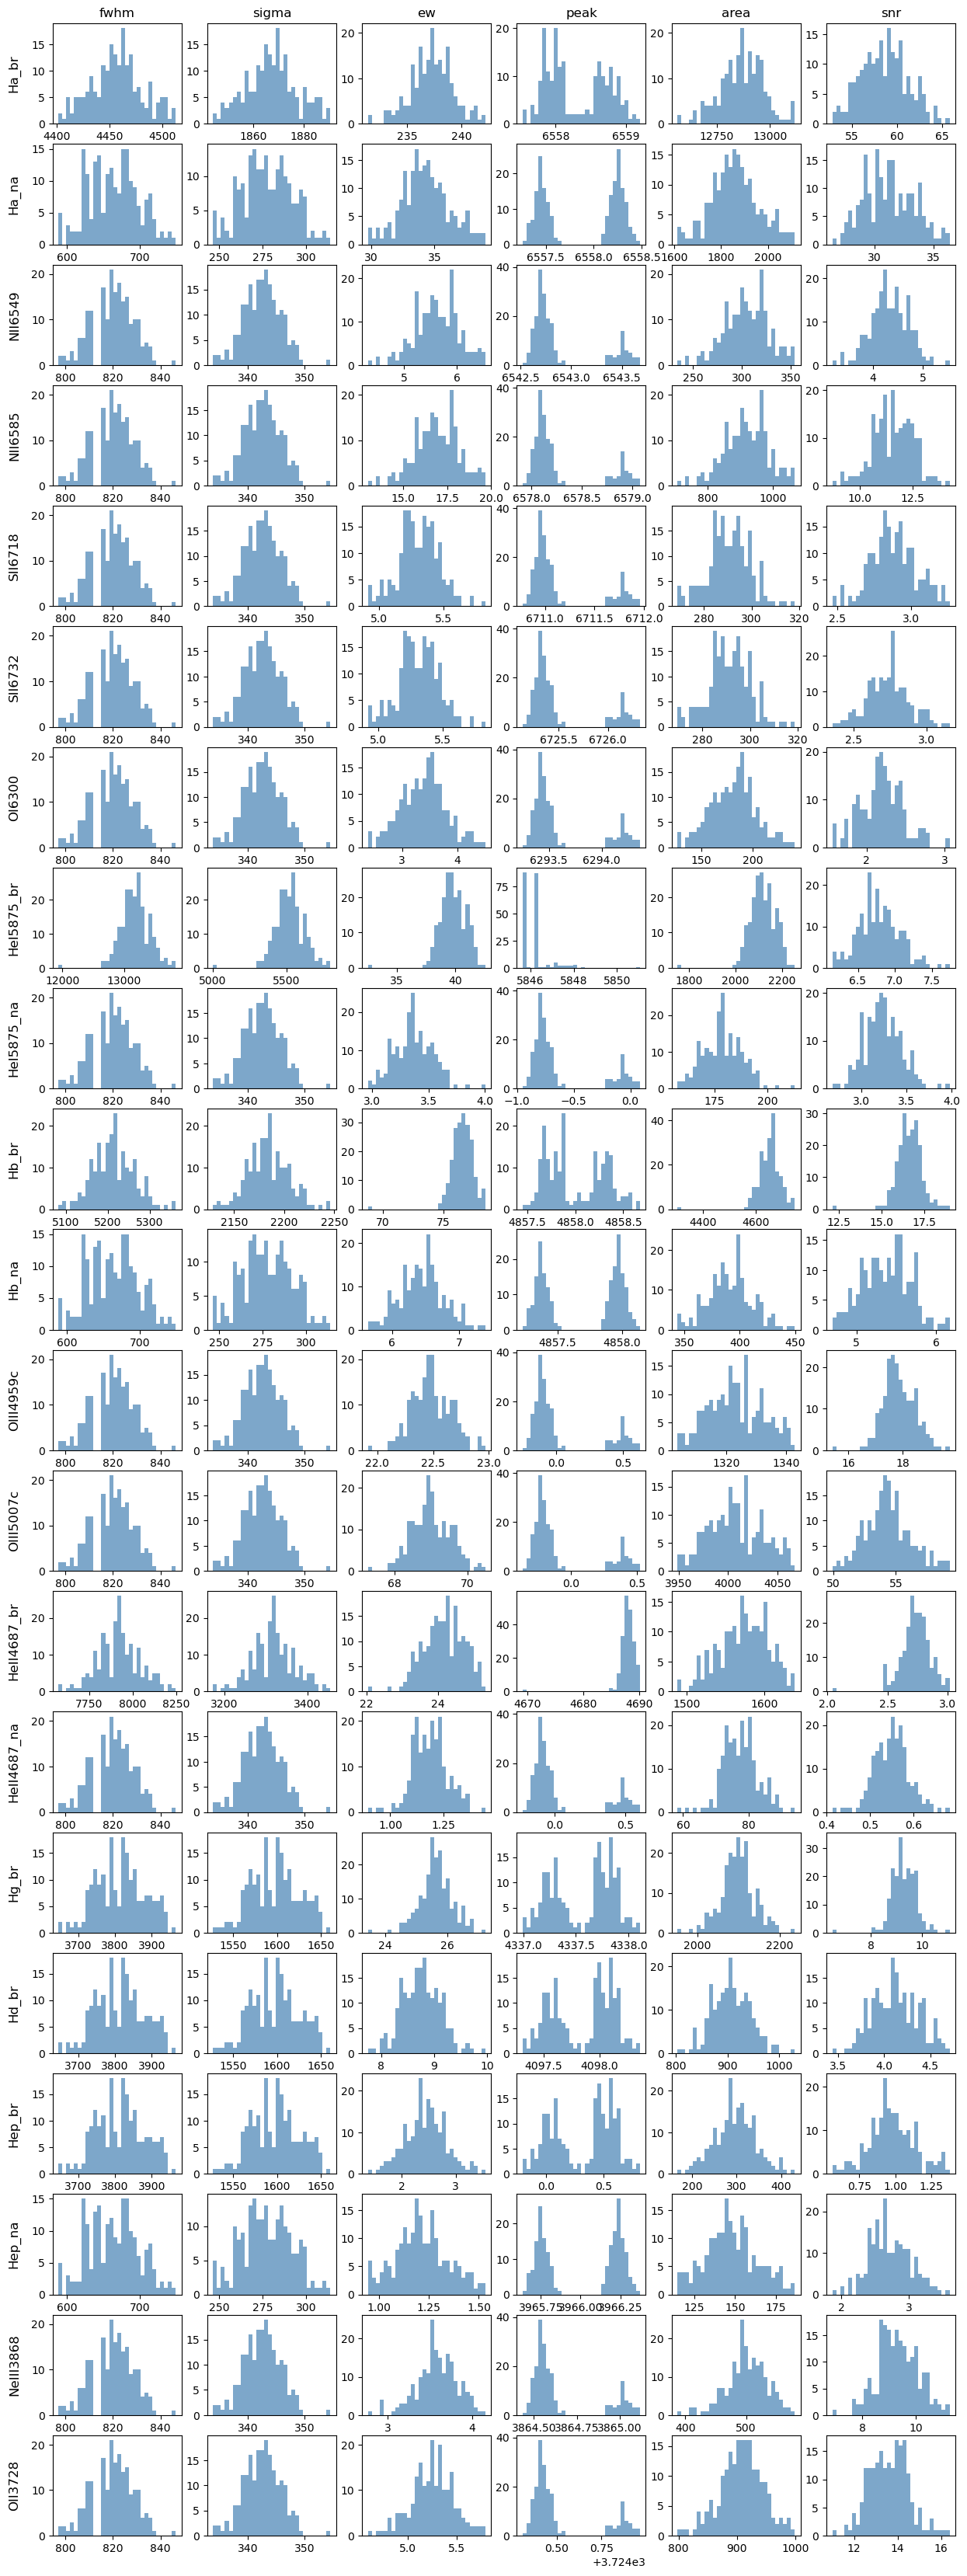

In [6]:
def plot_dataframe_histograms(df, selected_rows=None, bins=30):
    """
    Plots histograms for each cell in the DataFrame, arranged in a grid matching the DataFrame structure.
    
    Parameters:
    - df: Pandas DataFrame containing lists of float values in each cell.
    - selected_rows: List of row indexes to include (default: all rows).
    - bins: Number of bins for the histograms.
    """
    # Filter selected rows if specified
    if selected_rows is not None:
        df = df.loc[selected_rows]

    num_rows, num_cols = df.shape

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2.5 * num_cols, 2 * num_rows))
    # Ensure axes is always 2D (even if there's only one row/col)
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if num_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    # Iterate over rows and columns to plot histograms
    for i, row_label in enumerate(df.index):
        for j, col_label in enumerate(df.columns):
            ax = axes[i, j]
            ax.hist(df.loc[row_label, col_label], bins=bins, color='steelblue', alpha=0.7)
            #ax.set_xticks([])
            #ax.set_yticks([])
            ax.tick_params(axis='both', which='both', labelsize=10)
            
            # Column labels (top row)
            if i == 0:
                ax.set_title(col_label, fontsize=12, pad=6)

            # Row labels (left-most column)
            if j == 0:
                ax.set_ylabel(row_label, fontsize=12, rotation=90, labelpad=10)
    
    #plt.subplots_adjust(wspace=0, hspace=0)
    
    # Save figure
    custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
    custom_filename = "2022_ngauss1_fits200_line_parameters.png"
    save_path = custom_path + custom_filename
    #plt.savefig(save_path)
    plt.show()

plot_dataframe_histograms(df_22, selected_rows=['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII5007c', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hd_br', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728'])

# Average Results and Standard Deviation

In [7]:
# Function returning the imported dataframes as averaged single values and standard deviations
def lineParameterAverages(df):
    df_mean = df.copy()
    df_std = df.copy()
    for index, row in df.iterrows():
        for col in df.columns:
            df_mean.at[index, col] = np.mean(row[col])
            df_std.at[index, col] = np.std(row[col])
    
    # Combine mean and standard deviation dataframes into 1 line parameters df with means and std dev
    df_std = df_std.add_suffix('_std') # rename standard deviation columns
    df_combined = pd.concat([df_mean, df_std], axis=1) # concatenate dfs
    # Reorder columns for mean values and std dev to be next to each other
    new_column_order = [col for pair in zip(df_mean.columns, df_std.columns) for col in pair]
    df_combined = df_combined[new_column_order]
    # Order by snr value
    df_combined = df_combined.sort_values(by='snr', ascending=False)
    return df_combined

# Compute dataframe of line parameter averages including mean and std
line_params_04 = lineParameterAverages(df_04)
line_params_22 = lineParameterAverages(df_22)
line_params_24 = lineParameterAverages(df_24)

# Compute average of logl5100 measured from spectra
logL5100_04 = [np.mean(logL5100_04), np.std(logL5100_04)]
logL5100_22 = [np.mean(logL5100_22), np.std(logL5100_22)]
logL5100_24 = [np.mean(logL5100_24), np.std(logL5100_24)]

# Using CZBin1 Host fit on 2024 39.0502% Host contribution
L5100_host = (10**logL5100_24[0]) * 0.390502 # calculate the host continuum from 2024

logL5100_agn_04 = np.log10( 10**logL5100_04[0] - L5100_host )
logL5100_agn_22 = np.log10( 10**logL5100_22[0] - L5100_host )
logL5100_agn_24 = np.log10( 10**logL5100_24[0] - L5100_host )

In [78]:
line_params_22
#logL5100_agn_24

,fwhm,fwhm_std,sigma,sigma_std,ew,ew_std,peak,peak_std,area,area_std,snr,snr_std
Ha_br,4456.968039,24.205238,1867.248923,10.133096,237.28511,1.947463,6558.30048,0.423424,12868.232466,101.554498,58.656351,2.609922
OIII5007c,820.148788,8.61616,342.486282,3.213488,69.006062,0.532914,5002.926946,0.257682,4008.038443,27.069017,54.366222,1.815604
Ha_na,664.440014,33.813776,277.44803,14.177167,34.306148,1.877714,6557.882239,0.406651,1860.25192,101.420252,31.178263,2.08936
OIII4959c,820.148509,8.616157,342.486165,3.213487,22.48394,0.173632,4955.035693,0.255216,1323.223636,8.936632,17.871261,0.58985
Hb_br,5212.791155,48.41116,2183.989888,20.297084,76.5965,0.938026,4858.005873,0.30248,4650.741179,43.571048,16.638634,0.728575
OII3728,820.148759,8.61616,342.486269,3.213488,5.250147,0.215377,3724.524269,0.191836,908.130507,36.607035,13.611001,0.91037
NII6585,820.148782,8.61616,342.486279,3.213488,16.899973,1.243157,6578.293353,0.338823,917.501967,67.377853,11.559946,0.964371
NeIII3868,820.149163,8.616164,342.486438,3.213489,3.58488,0.238221,3864.657373,0.199054,500.907535,33.069118,9.319665,0.745274
Hg_br,3814.784528,65.050461,1598.171285,27.259255,25.641042,0.520316,4337.56809,0.287505,2097.977101,40.859265,9.295719,0.491018
HeI5875_br,13177.693568,237.893419,5523.425446,99.80703,39.827064,1.133861,5846.164955,0.675124,2117.908514,56.967722,6.787505,0.280519


In [79]:
print('Total L5100 from 2024', str(logL5100_24))
print('L5100 Host with 39% Host', str(np.log10((10**logL5100_24[0]) * 0.390502)))
print('L5100 AGN with 39% Host', str(np.log10((10**logL5100_24[0]) * (1-0.390502))))

Total L5100 from 2024 [43.60189764633682, 0.029614824836236366]
L5100 Host with 39% Host 43.19352090884397
L5100 AGN with 39% Host 43.38686993120445


## MC Continuum Luminosity with Errors

In [8]:
import random
vals_04 = np.zeros(10000,dtype=float)
vals_22 = np.zeros(10000,dtype=float)
vals_24 = np.zeros(10000,dtype=float)
for i in range(10000):
    vals_04[i] = 10**random.gauss(logL5100_04[0], logL5100_04[1])
    vals_22[i] = 10**random.gauss(logL5100_22[0], logL5100_22[1])
    vals_24[i] = 10**random.gauss(logL5100_24[0], logL5100_24[1])

L5100_host = [(np.mean(vals_24) * 0.390502), (np.std(vals_24) * 0.390502)]

print('Measured L5100 2004: ', str(np.mean(vals_04)), '+-', str(np.std(vals_04)))
print('Measured L5100 2022: ', str(np.mean(vals_22)), '+-', str(np.std(vals_22)))
print('Measured L5100 2024: ', str(np.mean(vals_24)), '+-', str(np.std(vals_24)))
print('Host L5100 2024 (39.0502%): ', str(np.mean(vals_24) * 0.390502), '+-', str(np.std(vals_24) * 0.390502))

L5100_agn_2004 = [(np.mean(vals_04) - L5100_host[0]), (np.sqrt( (np.std(vals_04))**2 + (L5100_host[1])**2 ))]
L5100_agn_2022 = [(np.mean(vals_22) - L5100_host[0]), (np.sqrt( (np.std(vals_22))**2 + (L5100_host[1])**2 ))]
L5100_agn_2024 = [(np.mean(vals_24) - L5100_host[0]), (np.sqrt( (np.std(vals_24))**2 + (L5100_host[1])**2 ))]
print('AGN L5100 2004: ', str(np.mean(vals_04) - L5100_host[0]), '+-', str(np.sqrt( (np.std(vals_04))**2 + (L5100_host[1])**2 )))
print('AGN L5100 2022: ', str(np.mean(vals_22) - L5100_host[0]), '+-', str(np.sqrt( (np.std(vals_22))**2 + (L5100_host[1])**2 )))
print('AGN L5100 2024: ', str(np.mean(vals_24) * (1-0.390502)), '+-', str(np.std(vals_24) * (1-0.390502)))

Measured L5100 2004:  2.3226976954369877e+43 +- 3.2930321253458184e+41
Measured L5100 2022:  3.9403093542705834e+43 +- 1.5590913337196939e+41
Measured L5100 2024:  4.009438624233259e+43 +- 2.7095097114647848e+42
Host L5100 2024 (39.0502%):  1.565693801640336e+43 +- 1.0580689613464214e+42
AGN L5100 2004:  7.570038937966516e+42 +- 1.1081292942388496e+42
AGN L5100 2022:  2.374615552630247e+43 +- 1.0694940789146491e+42
AGN L5100 2024:  2.443744822592923e+43 +- 1.6514407501183635e+42


In [9]:
L5100_agn_2024

[2.443744822592923e+43, 2.9087717001316337e+42]

# Seyfert Classification

Whittle Classification:
R = [OIII]5007 / HB_broad (Line fluxes)

Classification based on ratio bins Mark Whittle (1992)

Method 2:
Type ~ 1 + [I(HA_narrow) / I(HA_total)]^0.4 (Intensity equivalent in my case to flux)


Both methods given by Dalla Barba et al. 2023

In [10]:
print('[O III]5007 / Hb_br, Whittle 1992')
print('2004: ', str(line_params_04.loc['OIII5007c', 'area'] / line_params_04.loc['Hb_br', 'area']), '  Sy1.5: 1 < R < 4')
print('2022: ', str(line_params_22.loc['OIII5007c', 'area'] / line_params_22.loc['Hb_br', 'area']), '  Sy1.2: 0.3 < R < 1')
print('2024: ', str(line_params_24.loc['OIII5007c', 'area'] / line_params_24.loc['Hb_br', 'area']), '  Sy1.2: 0.3 < R < 1')

print('')
print('Hb / [O III]5007, Winkler 1992')
print('2004: ', str(line_params_04.loc['Hb_br', 'area'] / line_params_04.loc['OIII5007c', 'area']), '  Sy1.5: 0.333 < R < 2')
print('2022: ', str(line_params_22.loc['Hb_br', 'area'] / line_params_22.loc['OIII5007c', 'area']), '  Sy1.5: 0.333 < R < 2')
print('2024: ', str(line_params_24.loc['Hb_br', 'area'] / line_params_24.loc['OIII5007c', 'area']), '  Sy1.5: 0.333 < R < 2')

[O III]5007 / Hb_br, Whittle 1992
2004:  2.0960495196762254   Sy1.5: 1 < R < 4
2022:  0.8618063849769355   Sy1.2: 0.3 < R < 1
2024:  0.8074650294555124   Sy1.2: 0.3 < R < 1

Hb / [O III]5007, Winkler 1992
2004:  0.47708796505650736   Sy1.5: 0.333 < R < 2
2022:  1.1603534360293268   Sy1.5: 0.333 < R < 2
2024:  1.2384437263794783   Sy1.5: 0.333 < R < 2


In [11]:
print('Type 1: R < 0.3 --> R2 >', str(1/0.3))
print('Type 1.2: 0.3 < R < 1 --> R2', str(1/1), str(1/0.3))
print('Type 1.5: 1 < R < 4 --> R2', str(1/4), str(1/1))
print('Type 1.8: 4 < R --> R2 < ', str(1/4))

Type 1: R < 0.3 --> R2 > 3.3333333333333335
Type 1.2: 0.3 < R < 1 --> R2 1.0 3.3333333333333335
Type 1.5: 1 < R < 4 --> R2 0.25 1.0
Type 1.8: 4 < R --> R2 <  0.25


In [12]:
5.7 + (0.48154822560227534*3)

7.144644676806826

# Luminosity Calculation

In [13]:
# Convert from flux to luminosity
def luminosityCalculation(flux):
    # Create a FlatLambdaCDM cosmology instance
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # Hubble const km/s/Mpc and Density param for matter
    # Calculate luminosity distance to sources
    L_dist     = cosmo.luminosity_distance(0.074550).to(u.cm)
    L_dist_cm  = L_dist.value
    # Calculate luminosity from flux
    luminosity  = (flux * 4 * np.pi * L_dist_cm**2)
    return luminosity

# Broad Ha Luminosity
LHa_br_04 = luminosityCalculation(line_params_04.at['Ha_br', 'area']*1e-17)
LHa_br_04_err = luminosityCalculation(line_params_04.at['Ha_br', 'area_std']*1e-17)
LHa_br_22 = luminosityCalculation(line_params_22.at['Ha_br', 'area']*1e-17)
LHa_br_22_err = luminosityCalculation(line_params_22.at['Ha_br', 'area_std']*1e-17)
LHa_br_24 = luminosityCalculation(line_params_24.at['Ha_br', 'area']*1e-17)
LHa_br_24_err = luminosityCalculation(line_params_24.at['Ha_br', 'area_std']*1e-17)
# Broad & Narrow Ha Luminosity
LHa_combined_04 = luminosityCalculation((line_params_04.at['Ha_br', 'area'] + line_params_04.at['Ha_na', 'area'])*1e-17)
LHa_combined_22 = luminosityCalculation((line_params_22.at['Ha_br', 'area'] + line_params_22.at['Ha_na', 'area'])*1e-17)
LHa_combined_24 = luminosityCalculation((line_params_24.at['Ha_br', 'area'] + line_params_24.at['Ha_na', 'area'])*1e-17)
# Broad Hb Luminosity
LHb_br_04 = luminosityCalculation(line_params_04.at['Hb_br', 'area']*1e-17)
LHb_br_22 = luminosityCalculation(line_params_22.at['Hb_br', 'area']*1e-17)
LHb_br_24 = luminosityCalculation(line_params_24.at['Hb_br', 'area']*1e-17)
# Broad & Narrow Hb Luminosity
LHb_combined_04 = luminosityCalculation((line_params_04.at['Hb_br', 'area'] + line_params_04.at['Hb_na', 'area'])*1e-17)
LHb_combined_22 = luminosityCalculation((line_params_22.at['Hb_br', 'area'] + line_params_22.at['Hb_na', 'area'])*1e-17)
LHb_combined_24 = luminosityCalculation((line_params_24.at['Hb_br', 'area'] + line_params_24.at['Hb_na', 'area'])*1e-17)

print('LHa Broad + Narrow Flux 2004: ', str(LHa_combined_04))
print('LHa Broad + Narrow Flux 2022: ', str(LHa_combined_22))
print('LHa Broad + Narrow Flux 2024: ', str(LHa_combined_24))
#print('LHb Broad + Narrow Flux 2004: ', str(LHb_combined_04))
#print('LHb Broad + Narrow Flux 2022: ', str(LHb_combined_22))
#print('LHb Broad + Narrow Flux 2024: ', str(LHb_combined_24))

LHa Broad + Narrow Flux 2004:  6.3046054921299725e+41
LHa Broad + Narrow Flux 2022:  2.004247865461459e+42
LHa Broad + Narrow Flux 2024:  1.5907852869207463e+42


# Empirical Relationships
Greene & Ho 2005 Section 4.1

In [14]:
# Eq.3 Relationship between FWHM of Ha and Hb. Scatter ~0.1dex
def greeneLineWidthRelation(fwhm_ha):
    fwhm_hb = 1.07e3 * (fwhm_ha / 1e3)**1.03
    return fwhm_hb

# Print the measured and estimated HB Line Widths
print('Check Greene&Hos Balmer width relation')
print('2004 HAlpha FWHM = ', str(line_params_04.at['Ha_br', 'fwhm']))
print('2004 HBeta FWHM = ', str(line_params_04.at['Hb_br', 'fwhm']))
print('2004 Greene Estimated HBeta FWHM = ', str(greeneLineWidthRelation(line_params_04.at['Ha_br', 'fwhm'])))
print('2022 HAlpha FWHM = ', str(line_params_22.at['Ha_br', 'fwhm']))
print('2022 HBeta FWHM = ', str(line_params_22.at['Hb_br', 'fwhm']))
print('2022 Greene Estimated HBeta FWHM = ', str(greeneLineWidthRelation(line_params_22.at['Ha_br', 'fwhm'])))
print('2024 HAlpha FWHM = ', str(line_params_24.at['Ha_br', 'fwhm']))
print('2024 HBeta FWHM = ', str(line_params_24.at['Hb_br', 'fwhm']))
print('2024 Greene Estimated HBeta FWHM = ', str(greeneLineWidthRelation(line_params_24.at['Ha_br', 'fwhm'])))
print('')



# Eq.1,2 (Rearranged) L5100 from LHa and LHb. Scatter ~0.2dex
# Narrow and broad components combined but this should work for just broad as narrow only contributes ~7-10%
'''
def greeneHalphaL5100Continuum(LHa, LHa_err=None):
    logL5100 = 0.864*np.log10(LHa) + 7.077
    if LHa_err != None:
        logL5100_err = np.sqrt((0.375/LHa)**2 * (LHa_err)**2)
        return logL5100, logL5100_err
    return logL5100
'''
def greeneHalphaL5100Continuum(LHa):
    #logL5100 = 0.86*np.log10(LHa) + 7.08
    logL5100 = (np.log10(LHa) - np.log10(5.25e42) + 50.908)/1.157
    return logL5100

def greeneHbetaL5100Continuum(LHb):
    logL5100 = 0.88*np.log10(LHb) + 6.79
    return logL5100

# Calculate optical continuum luminosity from combined Halpha emission
logL5100_Ha_est_04 = greeneHalphaL5100Continuum(LHa_combined_04)
logL5100_Ha_est_22 = greeneHalphaL5100Continuum(LHa_combined_22)
logL5100_Ha_est_24 = greeneHalphaL5100Continuum(LHa_combined_24)
# Calculate optical continuum luminosity from combined Hbeta emission
logL5100_Hb_est_04 = greeneHbetaL5100Continuum(LHb_combined_04)
logL5100_Hb_est_22 = greeneHbetaL5100Continuum(LHb_combined_22)
logL5100_Hb_est_24 = greeneHbetaL5100Continuum(LHb_combined_24)

# Print logL5100 values
print('2004 logL5100 combined Ha: ', str(logL5100_Ha_est_04))
print('2022 logL5100 combined Ha: ', str(logL5100_Ha_est_22))
print('2024 logL5100 combined Ha: ', str(logL5100_Ha_est_24))
print('2004 logL5100 combined Hb: ', str(logL5100_Hb_est_04))
print('2022 logL5100 combined Hb: ', str(logL5100_Hb_est_22))
print('2024 logL5100 combined Hb: ', str(logL5100_Hb_est_24))
print('')

# Print logL5100 values measured directly from spectra without any host correction!
print('2004 logL5100 (no host decomp): ', str(logL5100_04[0]), '+-' , str(logL5100_04[1]))
print('2022 logL5100 (no host decomp): ', str(logL5100_22[0]), '+-' , str(logL5100_22[1]))
print('2024 logL5100 (no host decomp): ', str(logL5100_24[0]), '+-' , str(logL5100_24[1]))
print('')

# Subtracting L5100 from HA emission and L5100 from AGN and Host contributions, we can obtain an estimate of the Host luminosity
print('2004 L5100 from Host = ', str(10**logL5100_04[0] - 10**logL5100_Ha_est_04))
print('2022 L5100 from Host = ', str(10**logL5100_22[0] - 10**logL5100_Ha_est_22))
print('2024 L5100 from Host = ', str(10**logL5100_24[0] - 10**logL5100_Ha_est_24))

Check Greene&Hos Balmer width relation
2004 HAlpha FWHM =  5352.656587133162
2004 HBeta FWHM =  5352.652174320603
2004 Greene Estimated HBeta FWHM =  6022.963622988829
2022 HAlpha FWHM =  4456.9680394764255
2022 HBeta FWHM =  5212.791154893093
2022 Greene Estimated HBeta FWHM =  4987.632923777281
2024 HAlpha FWHM =  4299.9884911149875
2024 HBeta FWHM =  5392.948464976523
2024 Greene Estimated HBeta FWHM =  4806.789343414021

2004 logL5100 combined Ha:  43.20440675243761
2022 logL5100 combined Ha:  43.63854116364472
2024 logL5100 combined Ha:  43.55181699409034
2004 logL5100 combined Hb:  43.2921989366409
2022 logL5100 combined Hb:  43.60604038833808
2024 logL5100 combined Hb:  43.61328995699183

2004 logL5100 (no host decomp):  43.36594097396291 +- 0.006237584498424634
2022 logL5100 (no host decomp):  43.59552359361787 +- 0.0017264131254981505
2024 logL5100 (no host decomp):  43.60189764633682 +- 0.029614824836236366

2004 L5100 from Host =  7.2136428110154e+42
2022 L5100 from Host =  

# Bolometric Luminosity

Bolometric Luminosity Correction (Netzer, 2019)

k_BOL = c × (L(observed)/10^42 erg/sec))^d

**Parameters:**
L(5100), c = 40, d = -0.2, L(narrow HB), c = 4580, d = 0.18


Assuming accretion through an optically thick, geometrically thin disk is the only energy production: L_AGN = η M_dot c^2, η is mass-radiation conversion efficiency.

L_AGN = k_BOL * L_obs

In [15]:
def bol_correction(L, L_err=None):
    # Fitting constants from Table 1 using L5100
    c = 40
    d = -0.2
    k_bol = c * (L/10**42)**d
    # If error value provided, calculate and return uncertainty
    if L_err != None:
        k_bol_err = abs(c*d * (L**(d-1) / 10**(42*d))) * L_err
        return k_bol, k_bol_err
    return k_bol

def bol_luminosity(k_bol, L_obs, k_bol_err=None, L_obs_err=None):
    L_agn = k_bol * L_obs
    if (k_bol_err != None) & (L_obs_err != None):
        L_agn_err = L_agn * np.sqrt((k_bol_err/k_bol)**2 + (L_obs_err/L_obs)**2)
        return L_agn, L_agn_err 
    return L_agn


# Bolometric corrections
k_bol_Ha_04 = bol_correction(10**logL5100_Ha_est_04) # estimated from Ha emission
k_bol_Ha_22 = bol_correction(10**logL5100_Ha_est_22)
k_bol_Ha_24 = bol_correction(10**logL5100_Ha_est_24)
k_bol_Hb_04 = bol_correction(10**logL5100_Hb_est_04) # estimated from Hb emission
k_bol_Hb_22 = bol_correction(10**logL5100_Hb_est_22)
k_bol_Hb_24 = bol_correction(10**logL5100_Hb_est_24)
k_bol_measured_04 = bol_correction(10**logL5100_04[0]) # measured from L5100 directly (no host correction)
k_bol_measured_22 = bol_correction(10**logL5100_22[0])
k_bol_measured_24 = bol_correction(10**logL5100_24[0])

# Bolometric luminosity
L_bol_Ha_04 = bol_luminosity(k_bol_Ha_04, 10**logL5100_Ha_est_04) # estimated from Ha emission
L_bol_Ha_22 = bol_luminosity(k_bol_Ha_22, 10**logL5100_Ha_est_22)
L_bol_Ha_24 = bol_luminosity(k_bol_Ha_24, 10**logL5100_Ha_est_24)
L_bol_Hb_04 = bol_luminosity(k_bol_Hb_04, 10**logL5100_Hb_est_04) # estimated from Hb emission
L_bol_Hb_22 = bol_luminosity(k_bol_Hb_22, 10**logL5100_Hb_est_22)
L_bol_Hb_24 = bol_luminosity(k_bol_Hb_24, 10**logL5100_Hb_est_24)
L_bol_measured_04 = bol_luminosity(k_bol_measured_04, 10**logL5100_04[0]) # measured from L5100 directly (no host correction)
L_bol_measured_22 = bol_luminosity(k_bol_measured_22, 10**logL5100_22[0])
L_bol_measured_24 = bol_luminosity(k_bol_measured_24, 10**logL5100_24[0])

print("Bolometric Luminosity from Ha estimated L5100")
print("2004: " + str(L_bol_Ha_04))
print("2022: " + str(L_bol_Ha_22))
print("2024: " + str(L_bol_Ha_24))
print("Bolometric Luminosity from Hb estimated L5100")
print("2004: " + str(L_bol_Hb_04))
print("2022: " + str(L_bol_Hb_22))
print("2024: " + str(L_bol_Hb_24))
print("Bolometric Luminosity from measured L5100 (no host decomp)")
print("2004: " + str(L_bol_measured_04))
print("2022: " + str(L_bol_measured_22))
print("2024: " + str(L_bol_measured_24))
print('Bolometric Luminosity from 130*L_Ha Stern&Laor(2012)')
print('2004: ' + str(LHa_br_04*130))
print('2022: ' + str(LHa_br_22*130))
print('2024: ' + str(LHa_br_24*130))

Bolometric Luminosity from Ha estimated L5100
2004: 3.677777006659742e+44
2022: 8.182630158958078e+44
2024: 6.97450815803198e+44
Bolometric Luminosity from Hb estimated L5100
2004: 4.3233375071646956e+44
2022: 7.707123211845103e+44
2024: 7.810735961534368e+44
Bolometric Luminosity from measured L5100 (no host decomp)
2004: 4.95236642386623e+44
2022: 7.55925274365086e+44
2024: 7.64853235865844e+44
Bolometric Luminosity from 130*L_Ha Stern&Laor(2012)
2004: 5.855977716013195e+43
2022: 2.2764369238154776e+44
2024: 1.796100626920582e+44


# Eddington Ratio

(LaMassa, 2024)

L_Edd = 1.26 x 10^38 * M_BH/M_sun

λ_Edd = L_bol / L_Edd

SMBH mass: 5.04e+07 M_sun
Eddington luminosity: 6.345e+45 M_sun

2004 upper limit:  0.07804807048357537
Edd param from Ha: 0.05796085638076886
Edd param from Hb: 0.06813473026901969
2004 lower limit:  0.0

2022 upper limit:  0.11913195439182211
Edd param from Ha: 0.12895622834160467
Edd param from Hb: 0.12146235641305496
2022 lower limit:  0.041083883908246736

2024 upper limit:  0.12053897905204872
Edd param from Ha: 0.10991652428686585
Edd param from Hb: 0.12309526773233322
2024 lower limit:  0.042490908568473346

Eddington ratio calc L_5100_AGN:  7.609969086947006e+42
Eddington ratio calc L_bol from Netzer+19:  2.028459333494299e+44
Eddington ratio calc L_5100_AGN:  2.378824109584208e+43
Eddington ratio calc L_bol from Netzer+19:  5.0483546469328094e+44
Eddington ratio calc L_5100_AGN:  2.315440884359458e+43
Eddington ratio calc L_bol from Netzer+19:  4.940455016155089e+44
Eddington Ratio from 2024 Host Decomp (CZBIN1, 39% Host):
2004 Eddington Ratio = 0.031968017606830004
2022 Eddi

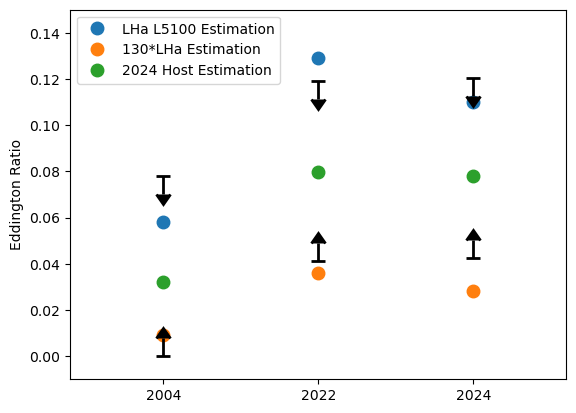

In [16]:
def EddingtonRatioCalc(l5100_agn, mass):
    k_bol = bol_correction(l5100_agn)
    l_bol = bol_luminosity(k_bol, l5100_agn)
    print('Eddington ratio calc L_5100_AGN: ', str(l5100_agn))
    print('Eddington ratio calc L_bol from Netzer+19: ', str(l_bol))
    l_edd = 1.26*10**38 * mass
    edd_ratio = l_bol/l_edd
    return edd_ratio

# (5.04+-0.38)e7
mass = 50359342.88187316 # Mass from 2024 Bonta Ha

print(r'SMBH mass: '+"{:.2e}".format(mass) + r" M_sun")

L_edd = 1.26*10**38 * mass

print(r'Eddington luminosity: '+"{:.3e}".format(L_edd) + r" M_sun")
print('')

# Edd_param = L_bol / L_edd from Ha
Edd_ratio_Ha_04 = L_bol_Ha_04 / L_edd
Edd_ratio_Ha_22 = L_bol_Ha_22 / L_edd
Edd_ratio_Ha_24 = L_bol_Ha_24 / L_edd

# Edd_param = L_bol / L_edd from Hb
Edd_ratio_Hb_04 = L_bol_Hb_04 / L_edd
Edd_ratio_Hb_22 = L_bol_Hb_22 / L_edd
Edd_ratio_Hb_24 = L_bol_Hb_24 / L_edd

# Lower limits on Edd param assuming no AGN contribution in 2004, only looks at different/increase to 2022 and 2024
Edd_ratio_low_lim_04 = (L_bol_measured_04 - L_bol_measured_04) / L_edd
Edd_ratio_low_lim_22 = (L_bol_measured_22 - L_bol_measured_04) / L_edd
Edd_ratio_low_lim_24 = (L_bol_measured_24 - L_bol_measured_04) / L_edd
# Upper limits on Edd param assuming only AGN contribution in all spectra, directly measured L5100
Edd_ratio_up_lim_04 = L_bol_measured_04 / L_edd
Edd_ratio_up_lim_22 = L_bol_measured_22 / L_edd
Edd_ratio_up_lim_24 = L_bol_measured_24 / L_edd

print('2004 upper limit: ', str(Edd_ratio_up_lim_04))
print('Edd param from Ha: ' + str(Edd_ratio_Ha_04))
print('Edd param from Hb: ' + str(Edd_ratio_Hb_04))
print('2004 lower limit: ', str(Edd_ratio_low_lim_04))
print('')
print('2022 upper limit: ', str(Edd_ratio_up_lim_22))
print('Edd param from Ha: ' + str(Edd_ratio_Ha_22))
print('Edd param from Hb: ' + str(Edd_ratio_Hb_22))
print('2022 lower limit: ', str(Edd_ratio_low_lim_22))
print('')
print('2024 upper limit: ', str(Edd_ratio_up_lim_24))
print('Edd param from Ha: ' + str(Edd_ratio_Ha_24))
print('Edd param from Hb: ' + str(Edd_ratio_Hb_24))
print('2024 lower limit: ', str(Edd_ratio_low_lim_24))
print('')


# Eddington ratio's using 2024 CZBIN host fit to calc L5100 AGN contribution from all spectra
host_24 = (10**(logL5100_24[0]) * 0.3905020025589776)

# Calculate Eddington ratios using the Host L5100 as measured by CZ prior host decomp from 2024 spectrum
Edd_ratio_04 = EddingtonRatioCalc((10**logL5100_04[0] - host_24), mass)
Edd_ratio_22 = EddingtonRatioCalc((10**logL5100_22[0] - host_24), mass)
Edd_ratio_24 = EddingtonRatioCalc(10**43.364633697476656, mass)
print('Eddington Ratio from 2024 Host Decomp (CZBIN1, 39% Host):')
print('2004 Eddington Ratio = '+str(Edd_ratio_04))
print('2022 Eddington Ratio = '+str(Edd_ratio_22))
print('2024 Eddington Ratio = '+str(Edd_ratio_24))
print(np.log10(Edd_ratio_04))
print(np.log10(Edd_ratio_22))
print(np.log10(Edd_ratio_24))

print(EddingtonRatioCalc(10**43.1422, mass))

# Eddington ratio from L_bol = 130*L_Ha (broad) relation used by Juodžbalis+25 from calibrations by Stern&Laor+12
Edd_ratio_130LHa_04 = (130*LHa_br_04) / (1.26*10**38 * mass)
Edd_ratio_130LHa_22 = (130*LHa_br_22) / (1.26*10**38 * mass)
Edd_ratio_130LHa_24 = (130*LHa_br_24) / (1.26*10**38 * mass)


plt.plot([1,2,3], [Edd_ratio_Ha_04, Edd_ratio_Ha_22, Edd_ratio_Ha_24], marker='o', markersize=9, linestyle='None', label='LHa L5100 Estimation')
plt.plot([1,2,3], [Edd_ratio_130LHa_04, Edd_ratio_130LHa_22, Edd_ratio_130LHa_24], marker='o', markersize=9, linestyle='None', label='130*LHa Estimation')
plt.plot([1,2,3], [Edd_ratio_04, Edd_ratio_22, Edd_ratio_24], marker='o', markersize=9, linestyle='None', label='2024 Host Estimation')
plt.errorbar([1,2,3], [Edd_ratio_up_lim_04, Edd_ratio_up_lim_22, Edd_ratio_up_lim_24], yerr=np.full(3, 0.008), 
             uplims=True,
             marker="None", color="black",
             markeredgecolor="black", markerfacecolor="black",
             capsize=5, capthick=2, linewidth=2.0, linestyle="None")
plt.errorbar([1,2,3], [Edd_ratio_low_lim_04, Edd_ratio_low_lim_22, Edd_ratio_low_lim_24], yerr=np.full(3, 0.008), 
             lolims=True,
             marker="None", color="black",
             markeredgecolor="black", markerfacecolor="black",
             capsize=5, capthick=2, linewidth=2.0, linestyle="None")
#plt.vlines(1, Edd_ratio_low_lim_04, Edd_ratio_up_lim_04, capstyle= 'projecting')
#plt.vlines(2, Edd_ratio_low_lim_22, Edd_ratio_up_lim_22)
#plt.vlines(3, Edd_ratio_low_lim_24, Edd_ratio_up_lim_24)
plt.ylabel('Eddington Ratio')
plt.xlim(0.4, 3.6)
plt.ylim(-0.01, 0.15)
plt.xticks([1,2,3], ['2004', '2022', '2024'])
plt.legend()
plt.show()

## MC Eddington Ratio

In [17]:
bh_mass = [50580708.81727839, 3778045.3580698445] # MC error from Bonta+24 2024 Ha mass estimate

edd_vals_04 = np.zeros(10000,dtype=float)
edd_vals_22 = np.zeros(10000,dtype=float)
edd_vals_24 = np.zeros(10000,dtype=float)

for i in range(10000):
    edd_vals_04[i] = EddingtonRatioCalc(random.gauss(L5100_agn_2004[0], L5100_agn_2004[1]), random.gauss(bh_mass[0], bh_mass[1]))
    edd_vals_22[i] = EddingtonRatioCalc(random.gauss(L5100_agn_2022[0], L5100_agn_2022[1]), random.gauss(bh_mass[0], bh_mass[1]))
    edd_vals_24[i] = EddingtonRatioCalc(random.gauss(L5100_agn_2024[0], L5100_agn_2024[1]), random.gauss(bh_mass[0], bh_mass[1]))

edd_ratio_04 = [np.mean(edd_vals_04), np.std(edd_vals_04)]
edd_ratio_22 = [np.mean(edd_vals_22), np.std(edd_vals_22)]
edd_ratio_24 = [np.mean(edd_vals_24), np.std(edd_vals_24)]

print('Eddington Ratio 2004: ', str(edd_ratio_04[0]), '+-', str(edd_ratio_04[1]))
print('Eddington Ratio 2022: ', str(edd_ratio_22[0]), '+-', str(edd_ratio_22[1]))
print('Eddington Ratio 2024: ', str(edd_ratio_24[0]), '+-', str(edd_ratio_24[1]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
print('2004 with host', str(10**logL5100_04[0]))
print('2004 without host', str((10**logL5100_04[0] - host_24)))
1 - (10**logL5100_04[0] - host_24) / 10**logL5100_04[0]

2004 with host 2.3224211289067904e+43
2004 without host 7.609969086947006e+42


0.6723260483541516

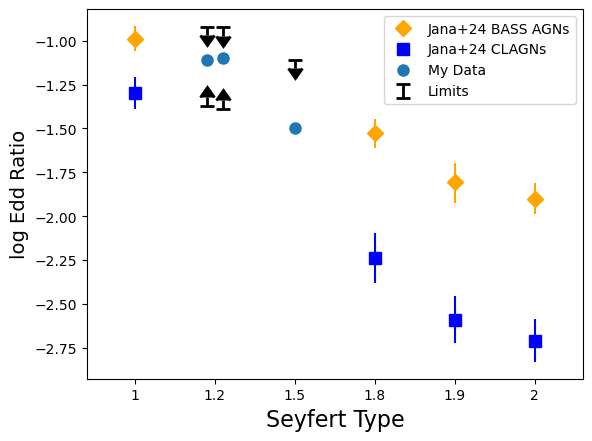

Median Eddington ratio's in each spectral state between CLAGNS and other AGNs from BASS sample for which CL transitions were not detected.
My Source, while appearing to fit into the non-CLAGN distribution, are completely within the natural spread of CLAGN also seen in Jana+24 from CLAGN.


In [19]:
# Jana+24 logEddRatio plot results from plot digitizer
#x = [1.0098199672667758, 1.0098199672667758, 1.6039279869067102, 1.6039279869067102, 1.8019639934533553, 1.8019639934533553, 2, 2]
#y = [-1.2989323843416372, -0.9893238434163703, -1.5266903914590748, -2.2384341637010676, -1.8078291814946619, -2.590747330960854, -1.900355871886121, -2.711743772241993]
#x = [1.0081037277147489, 1.0081037277147489, 1.0081037277147489, 1.0081037277147489, 1.6029173419773095, 1.6029173419773095, 1.6029173419773095, 1.6029173419773095, 1.8006482982171799, 1.8006482982171799, 1.8006482982171799, 1.8006482982171799, 1.9983792544570502, 1.9983792544570502, 1.9983792544570502, 1.9983792544570502]
jana_errors = np.array([-0.915492957746479, -1.0598591549295775, -1.2077464788732395, -1.3908450704225352, -1.4471830985915493, -1.6091549295774648, -2.0985915492957745, -2.380281690140845, -1.6971830985915493, -1.9225352112676055, -2.4577464788732395, -2.721830985915493, -1.8098591549295775, -1.9894366197183098, -2.5880281690140845, -2.830985915492958])
jana_color = ['orange', 'blue'] # 0 agn, 1 clagn
jana_marker = ['D', 's']
plt.vlines(1, jana_errors[1], jana_errors[0],   color=jana_color[0])
plt.vlines(1, jana_errors[3], jana_errors[2],   color=jana_color[1])
plt.vlines(4, jana_errors[5], jana_errors[4],   color=jana_color[0])
plt.vlines(4, jana_errors[7], jana_errors[6],   color=jana_color[1])
plt.vlines(5, jana_errors[9], jana_errors[8],   color=jana_color[0])
plt.vlines(5, jana_errors[11], jana_errors[10], color=jana_color[1])
plt.vlines(6, jana_errors[13], jana_errors[12], color=jana_color[0])
plt.vlines(6, jana_errors[15], jana_errors[14], color=jana_color[1])
plt.plot([1, 4, 5, 6], [-0.9893238434163703, -1.5266903914590748, -1.8078291814946619, -1.900355871886121], marker=jana_marker[0], markersize=8, linestyle='None', color=jana_color[0], label='Jana+24 BASS AGNs')
plt.plot([1, 4, 5, 6], [-1.2989323843416372, -2.2384341637010676, -2.590747330960854, -2.711743772241993], marker=jana_marker[1], markersize=8, linestyle='None', color=jana_color[1], label='Jana+24 CLAGNs')

plt.plot([1.9, 2.1, 3], [np.log10(Edd_ratio_24), np.log10(Edd_ratio_22), np.log10(Edd_ratio_04)], marker='o', markersize=8, linestyle='None', label='My Data')
#plt.vlines(1, np.log10(Edd_ratio_low_lim_24), np.log10(Edd_ratio_up_lim_24), capstyle= 'projecting') # lines showing the upper and lower limits.
#plt.vlines(2, np.log10(Edd_ratio_low_lim_22), np.log10(Edd_ratio_up_lim_22))
#plt.vlines(3, np.log10(Edd_ratio_Ha_04), np.log10(Edd_ratio_up_lim_04))
plt.errorbar([3,2.1,1.9], [np.log10(Edd_ratio_up_lim_04), np.log10(Edd_ratio_up_lim_22), np.log10(Edd_ratio_up_lim_24)], yerr=np.full(3, 0.05), 
             uplims=True,
             marker="None", color="black", label='Limits',
             markeredgecolor="black", markerfacecolor="black",
             capsize=5, capthick=2, linewidth=2.0, linestyle="None")
plt.errorbar([2.1,1.9], [np.log10(Edd_ratio_low_lim_22), np.log10(Edd_ratio_low_lim_24)], yerr=np.full(2, 0.05), 
             lolims=True,
             marker="None", color="black",
             markeredgecolor="black", markerfacecolor="black",
             capsize=5, capthick=2, linewidth=2.0, linestyle="None")
#plt.plot([2,3], [np.log10(0.034), np.log10(0.007)], marker='o', linestyle='None', color='red', label='Old values')
plt.ylabel('log Edd Ratio', fontsize=14)
plt.xlabel('Seyfert Type', fontsize=16)
plt.xlim(0.4, 6.6)
#plt.ylim(-3.8, -0.3)
plt.xticks([1,2,3,4,5,6], ['1', '1.2', '1.5', '1.8', '1.9', '2'])
plt.legend()
plt.show()
print("Median Eddington ratio's in each spectral state between CLAGNS and other AGNs from BASS sample for which CL transitions were not detected.")
print("My Source, while appearing to fit into the non-CLAGN distribution, are completely within the natural spread of CLAGN also seen in Jana+24 from CLAGN.")

In [20]:
# Eddington ratio's using 2024 CZBIN host fit to calc L5100 AGN contribution from all spectra
host_24 = (10**(logL5100_24[0]) * 0.3905020025589776)

# Calculate Eddington ratios using the Host L5100 as measured by CZ prior host decomp from 2024 spectrum
Edd_ratio_04 = EddingtonRatioCalc((10**logL5100_04[0] - host_24), mass)
Edd_ratio_22 = EddingtonRatioCalc((10**logL5100_22[0] - host_24), mass)
Edd_ratio_24 = EddingtonRatioCalc(10**43.364633697476656, mass)
print(np.log10(Edd_ratio_04))
print(np.log10(Edd_ratio_22))
print(np.log10(Edd_ratio_24))

Eddington ratio calc L_5100_AGN:  7.609969086947006e+42
Eddington ratio calc L_bol from Netzer+19:  2.028459333494299e+44
Eddington ratio calc L_5100_AGN:  2.378824109584208e+43
Eddington ratio calc L_bol from Netzer+19:  5.0483546469328094e+44
Eddington ratio calc L_5100_AGN:  2.315440884359458e+43
Eddington ratio calc L_bol from Netzer+19:  4.940455016155089e+44
-1.495284294260324
-1.0993007431654973
-1.1086836503529502


# BLR Radius

Kaspi+05 Relation

In [21]:
# Function calculating the size of the BLR scaling with source luminosity from Kaspi+05
def radiusBLR(l5100):
    radius = 2.23 * (l5100 / 1e44)**(0.69) * 10 # in light days
    #radius = 32.9 * (l5100 / 1e44)**(0.7) # alternative from Kaspi+00
    return radius

r_blr_04 = radiusBLR(10**logL5100_04[0] - host_24)
r_blr_22 = radiusBLR(10**logL5100_22[0] - host_24)
r_blr_24 = radiusBLR(10**logL5100_24[0] - host_24)
r_blr_upper_lim_04 = radiusBLR(10**logL5100_04[0]) # No host contribution upper limit on L5100
r_blr_upper_lim_22 = radiusBLR(10**logL5100_22[0])
r_blr_upper_lim_24 = radiusBLR(10**logL5100_24[0])
r_blr_lower_lim_04 = radiusBLR(10**logL5100_04[0] - 10**logL5100_04[0]) # 100% dim state host lower limit on L5100
r_blr_lower_lim_22 = radiusBLR(10**logL5100_22[0] - 10**logL5100_04[0])
r_blr_lower_lim_24 = radiusBLR(10**logL5100_24[0] - 10**logL5100_04[0])

print('R_BLR in light-days for 2004,22,24:')
print(r_blr_04)
print(r_blr_22)
print(r_blr_24)
print('R_BLR upper-limits in lt-days:')
print(r_blr_upper_lim_04)
print(r_blr_upper_lim_22)
print(r_blr_upper_lim_24)
print('R_BLR lower-limits in lt-days:')
print(r_blr_lower_lim_04)
print(r_blr_lower_lim_22)
print(r_blr_lower_lim_24)

R_BLR in light-days for 2004,22,24:
3.771021938057539
8.279323872487806
8.418701562228026
R_BLR upper-limits in lt-days:
8.143369387833477
11.727788969410163
11.847159597014818
R_BLR lower-limits in lt-days:
0.0
6.345531945603426
6.502328900819241


# BPT Diagram

In [22]:
# Narrow Line Fluxes for BPT Ratios
# 2004 OIII, Hb, Ha, NII, OII snr>3
Ha_04_flux_mean = line_params_04.at['Ha_na', 'area']
Ha_04_flux_std = line_params_04.at['Ha_na', 'area_std']
Hb_04_flux_mean = line_params_04.at['Hb_na', 'area']
Hb_04_flux_std = line_params_04.at['Hb_na', 'area_std']
NII_04_flux_mean = line_params_04.at['NII6549', 'area'] + line_params_04.at['NII6585', 'area']
NII_04_flux_std = np.sqrt( line_params_04.at['NII6549', 'area_std']**2 + line_params_04.at['NII6585', 'area_std']**2 ) # sum in quadrature
OII_04_flux_mean = line_params_04.at['OII3728', 'area']
OII_04_flux_std = line_params_04.at['OII3728', 'area_std']
OIII_04_flux_mean = line_params_04.at['OIII4959c', 'area'] + line_params_04.at['OIII5007c', 'area']
OIII_04_flux_std = np.sqrt( line_params_04.at['OIII4959c', 'area_std']**2 + line_params_04.at['OIII5007c', 'area_std']**2 )

# 2022 OIII, Hb, Ha, NII, OII, SII snr>3
Ha_22_flux_mean = line_params_22.at['Ha_na', 'area']
Ha_22_flux_std = line_params_22.at['Ha_na', 'area_std']
Hb_22_flux_mean = line_params_22.at['Hb_na', 'area']
Hb_22_flux_std = line_params_22.at['Hb_na', 'area_std']
NII_22_flux_mean = line_params_22.at['NII6549', 'area'] + line_params_22.at['NII6585', 'area']
NII_22_flux_std = np.sqrt( line_params_22.at['NII6549', 'area_std']**2 + line_params_22.at['NII6585', 'area_std']**2 ) # sum in quadrature
OII_22_flux_mean = line_params_22.at['OII3728', 'area']
OII_22_flux_std = line_params_22.at['OII3728', 'area_std']
OIII_22_flux_mean = line_params_22.at['OIII4959c', 'area'] + line_params_22.at['OIII5007c', 'area']
OIII_22_flux_std = np.sqrt( line_params_22.at['OIII4959c', 'area_std']**2 + line_params_22.at['OIII5007c', 'area_std']**2 )
SII_22_flux_mean = line_params_22.at['SII6718', 'area'] + line_params_22.at['SII6732', 'area']
SII_22_flux_std = np.sqrt( line_params_22.at['SII6718', 'area_std']**2 + line_params_22.at['SII6732', 'area_std']**2 )

# 2024 OIII, Hb, Ha, NII, OII, SII snr>3
Ha_24_flux_mean = line_params_24.at['Ha_na', 'area']
Ha_24_flux_std = line_params_24.at['Ha_na', 'area_std']
Hb_24_flux_mean = line_params_24.at['Hb_na', 'area']
Hb_24_flux_std = line_params_24.at['Hb_na', 'area_std']
NII_24_flux_mean = line_params_24.at['NII6549', 'area'] + line_params_24.at['NII6585', 'area']
NII_24_flux_std = np.sqrt( line_params_24.at['NII6549', 'area_std']**2 + line_params_24.at['NII6585', 'area_std']**2 ) # sum in quadrature
OII_24_flux_mean = line_params_24.at['OII3728', 'area']
OII_24_flux_std = line_params_24.at['OII3728', 'area_std']
OIII_24_flux_mean = line_params_24.at['OIII4959c', 'area'] + line_params_24.at['OIII5007c', 'area']
OIII_24_flux_std = np.sqrt( line_params_24.at['OIII4959c', 'area_std']**2 + line_params_24.at['OIII5007c', 'area_std']**2 )
SII_24_flux_mean = line_params_24.at['SII6718', 'area'] + line_params_24.at['SII6732', 'area']
SII_24_flux_std = np.sqrt( line_params_24.at['SII6718', 'area_std']**2 + line_params_24.at['SII6732', 'area_std']**2 )

In [23]:
# Function to calculate the uncertainty in logspace and propagate for all fluxes
def log10_ratio_with_error(A, sigma_A, B, sigma_B):
    log_value = np.log10(A / B)
    error = (1 / np.log(10)) * np.sqrt((sigma_A / A) ** 2 + (sigma_B / B) ** 2)
    return log_value, error


# BPT Boundary Lines
# NII Plot
NII_x_fit1 = np.linspace(-1.28, 0, 50) # -1.3036
NII_y_fit1 = 0.61/(NII_x_fit1 - 0.05) + 1.3 # (1)
NII_x_fit2 = np.linspace(-2.2, 0.465, 100)
NII_y_fit2 = 0.61/(NII_x_fit2 - 0.47) + 1.19 # (5)

# SII Plot
SII_x_fit1 = np.linspace(-3, 0.31, 100)
SII_y_fit1 = 0.72/(SII_x_fit1 - 0.32) + 1.3 # (2)
SII_x_fit2 = np.linspace(-0.3150, 2, 100)
SII_y_fit2 = 1.89 * SII_x_fit2 + 0.76 # (9)

# OI Plot
#OI_x_fit1 = np.linspace(-2.5, -0.9, 100)
#OI_y_fit1 = 0.73/(OI_x_fit1 + 0.59) + 1.33 # (3)
#OI_x_fit2 = np.linspace(-1.125, 0.2, 50)
#OI_y_fit2 = 1.18 * OI_x_fit2 + 1.3 # (10)

# OIII Plot
OIII_x_fit1 = np.linspace(-2.5, 0, 50)
OIII_y_fit1 = -1.701 * OIII_x_fit1 - 2.163 # (16)
OIII_x_fit2 = np.linspace(-1.05998, 0.5, 50)
OIII_y_fit2 = 1.0 * OIII_x_fit2 + 0.7 # (18)

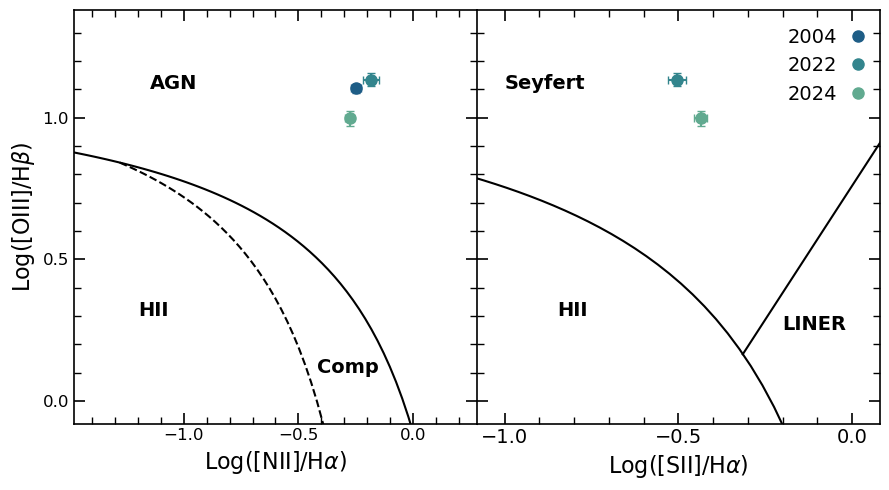

In [24]:
# Plotting triple BPT Figure
fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True) # was 14,5 with 3 plots
# Generate a seaborn palette with as many colors as you need
colors = sns.color_palette("crest", n_colors=3) # crest

# NII Plot
y_04, y_err_04 = log10_ratio_with_error(OIII_04_flux_mean, OIII_04_flux_std, Hb_04_flux_mean, Hb_04_flux_std)
x_04, x_err_04 = log10_ratio_with_error(NII_04_flux_mean, NII_04_flux_std, Ha_04_flux_mean, Ha_04_flux_std)
y_22, y_err_22 = log10_ratio_with_error(OIII_22_flux_mean, OIII_22_flux_std, Hb_22_flux_mean, Hb_22_flux_std)
x_22, x_err_22 = log10_ratio_with_error(NII_22_flux_mean, NII_22_flux_std, Ha_22_flux_mean, Ha_22_flux_std)
y_24, y_err_24 = log10_ratio_with_error(OIII_24_flux_mean, OIII_24_flux_std, Hb_24_flux_mean, Hb_24_flux_std)
x_24, x_err_24 = log10_ratio_with_error(NII_24_flux_mean, NII_24_flux_std, Ha_24_flux_mean, Ha_24_flux_std)
ax[0].errorbar(x_04, y_04, xerr=x_err_04, yerr=y_err_04, color=colors[2], capsize=3)
ax[0].plot(x_04, y_04, linestyle='None', marker='o', markersize=8, color=colors[2])
ax[0].errorbar(x_22, y_22, xerr=x_err_22, yerr=y_err_22, color=colors[1], capsize=3)
ax[0].plot(x_22, y_22, linestyle='None', marker='o', markersize=8, color=colors[1])
ax[0].errorbar(x_24, y_24, xerr=x_err_24, yerr=y_err_24, color=colors[0], capsize=3)
ax[0].plot(x_24, y_24, linestyle='None', marker='o', markersize=8, color=colors[0])

ax[0].plot(NII_x_fit1, NII_y_fit1, marker='None', linestyle='--', color = 'black') # BPT lines
ax[0].plot(NII_x_fit2, NII_y_fit2, marker='None', linestyle='-', color = 'black')

ax[0].text(-1.15, 1.1, 'AGN', color='black', fontsize=14, weight='bold') # BPT labels
ax[0].text(-1.2, 0.3, 'HII', color='black', fontsize=14, weight='bold')
ax[0].text(-0.42, 0.1, 'Comp', color='black', fontsize=14, weight='bold')

ax[0].set_xlabel(r'Log([NII]/H$\alpha$)', fontsize=16) # Axis
ax[0].set_ylabel(r'Log([OIII]/H$\beta$)', fontsize=16)
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks([y / 10.0 for y in range(0, 15, 5)]) # for loop to set intervals to 0.5 with range() not accepting floats
ax[0].set_xticks([x / 10.0 for x in range(-15, 1, 5)])
ax[0].set_ylim(-0.08, 1.38)
#ax[0].set_ylim(-0.08, 2)
ax[0].set_xlim(-1.48, 0.28)


# SII Plot
#x_04, x_err_04 = log10_ratio_with_error(SII_04_flux_mean, SII_04_flux_std, Ha_04_flux_mean, Ha_04_flux_std) # low SNR in SII 2004
x_22, x_err_22 = log10_ratio_with_error(SII_22_flux_mean, SII_22_flux_std, Ha_22_flux_mean, Ha_22_flux_std)
x_24, x_err_24 = log10_ratio_with_error(SII_24_flux_mean, SII_24_flux_std, Ha_24_flux_mean, Ha_24_flux_std)
#ax[1].errorbar(x_04, y_04, xerr=x_err_04, yerr=y_err_04, color='green', capsize=3)
ax[1].plot(100, 100, linestyle='None', marker='o', markersize=8, color=colors[2], label='2004') # include this for the legend label
ax[1].errorbar(x_22, y_22, xerr=x_err_22, yerr=y_err_22, color=colors[1], capsize=3)
ax[1].plot(x_22, y_22, linestyle='None', marker='o', markersize=8, color=colors[1], label='2022')
ax[1].errorbar(x_24, y_24, xerr=x_err_24, yerr=y_err_24, color=colors[0], capsize=3)
ax[1].plot(x_24, y_24, linestyle='None', marker='o', markersize=8, color=colors[0], label='2024')

ax[1].plot(SII_x_fit1, SII_y_fit1, marker='None', linestyle='-', color = 'black') # BPT lines
ax[1].plot(SII_x_fit2, SII_y_fit2, marker='None', linestyle='-', color = 'black')

ax[1].text(-1, 1.1, 'Seyfert', color='black', fontsize=14, weight='bold') # BPT labels was -0.35, 1.25
ax[1].text(-0.85, 0.3, 'HII', color='black', fontsize=14, weight='bold')
ax[1].text(-0.2, 0.25, 'LINER', color='black', fontsize=14, weight='bold')

ax[1].set_xlabel(r'Log([SII]/H$\alpha$)', fontsize=16) # Axis
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].set_yticks([y / 10.0 for y in range(0, 15, 5)]) # for loop to set intervals to 0.5 with range() not accepting floats
ax[1].set_xticks([x / 10.0 for x in range(-10, 1, 5)])
ax[1].set_xlim(-1.08, 0.08)


# More customization? Add ticks inside axis rather than outside
'''
ax[0].tick_params(labelsize=16)
ax[1].tick_params(labelsize=16)
#ax[2].tick_params(labelsize=16)
ax[1].tick_params(axis='y', size=0)
#ax[2].tick_params(axis='y', size=0)
ax[0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=16, size=6, width=1.5)
ax[0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=16, size=3, width=1.2)
ax[1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=16, size=6, width=1.5)
ax[1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=16, size=3, width=1.2)
#ax[2].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=16, size=6, width=1.5)
#ax[2].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=16, size=3, width=1.2)
ax[0].minorticks_on()
ax[1].minorticks_on()
#ax[2].minorticks_on()
'''
# consistent values used from BP
ax[0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=12, size=8, width=1.2)
ax[1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax[0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].spines['left'].set_linewidth(1.2)
ax[0].spines['top'].set_linewidth(1.2)
ax[0].spines['bottom'].set_linewidth(1.2)
ax[1].spines['left'].set_linewidth(1.2)
ax[1].spines['right'].set_linewidth(1.2)
ax[1].spines['bottom'].set_linewidth(1.2)
ax[1].spines['top'].set_linewidth(1.2)


ax[1].legend(loc='upper right', frameon=False, fontsize=14, markerfirst=False, handlelength = 0.5)

#ax[0].quiver(NII_x_09, y_09, (NII_x_22 - NII_x_09), (y_22 - y_09), angles='xy', scale_units='xy', scale=1.22, color='black', width=0.008, headlength=4, headaxislength=3.5) # Arrows
#ax[1].quiver(SII_x_09, y_09, (SII_x_22 - SII_x_09), (y_22 - y_09), angles='xy', scale_units='xy', scale=1.088, color='black', width=0.008, headlength=4, headaxislength=3.5)
#ax[2].quiver(OI_x_09, y_09, (OI_x_22+0.004 - OI_x_09), (y_22 - y_09), angles='xy', scale_units='xy', scale=1.22, color='black', width=0.008, headlength=4, headaxislength=3.5)
plt.tight_layout()
plt.subplots_adjust(wspace=0)  # Adjust the width space between subplots

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "bpt_evolution_for_paper.png"
save_path = custom_path + custom_filename
plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()

# Single-epoch Black Hole Mass

In [25]:
# 2D array of model constants for logM determination
log_models_array = np.array([
    # Model                 A               B       C       D       E
    #['KaspiHb',             6.38021124,     42,     0.59,   3,      2       ],
    #['KaspiHa',             6.11394335,     42,     0.57,   3,      2.06    ], # 2005
    ['GreeneHb',            6.5563025,      42,     0.56,   3,      2       ],
    ['GreeneHa',            6.30103,        42,     0.55,   3,      2.06    ], # 2005
    ['BontaHb',             7.70,           42,     0.784,  3.5,    1.387   ], # 2020
    ['BontaHa',             7.37,           42,     0.812,  3.5,    1.634   ], # 2024
    ['LaMassaHbL5100',      0.85,           44,     0.5,    0,      2       ],
    ['LaMassaHaL5100',      0.807,          44,     0.519,  0,      2.06    ], # 2024
    ['VestergaardHbL5100',  6.91,           44,     0.5,    3,      2       ],
    ['VestergaardHb',       6.67,           42,     0.63,   3,      2       ], # 2006
])
log_models_df = pd.DataFrame(log_models_array, columns=['model', 'a', 'b', 'c', 'd', 'e'])
# Convert all columns except 'Model' to float
for col in log_models_df.columns[1:]:  # Skip the first column ('Model')
    log_models_df[col] = log_models_df[col].astype(float)
log_models_df

,model,a,b,c,d,e
0,GreeneHb,6.556303,42.0,0.560,3.0,2.000
1,GreeneHa,6.301030,42.0,0.550,3.0,2.060
2,BontaHb,7.700000,42.0,0.784,3.5,1.387
3,BontaHa,7.370000,42.0,0.812,3.5,1.634
4,LaMassaHbL5100,0.850000,44.0,0.500,0.0,2.000
5,LaMassaHaL5100,0.807000,44.0,0.519,0.0,2.060
6,VestergaardHbL5100,6.910000,44.0,0.500,3.0,2.000
7,VestergaardHb,6.670000,42.0,0.630,3.0,2.000


In [26]:
# General BH mass equation - this is equivalent to Bonta and LaMassa but may need to add those separately
def generalMassCalculation(fit_params, model_params, model, line, conti_lum = None):
    
    a, b, c, d, e = model_params.loc[model_params['model'] == model, ['a', 'b', 'c', 'd', 'e']].values[0].astype(float)
    
    # Check whether the luminosity L is from continuum (LaMassa or Vestergaard)
    if model.endswith("L5100"):
        # Get line width and luminosity from dataframe
        fwhm, fwhm_err = fit_params.loc[line, ['fwhm', 'fwhm_std']]
        L = 10**np.array(conti_lum)
    else:
        fwhm, fwhm_err = fit_params.loc[line, ['fwhm', 'fwhm_std']]
        L = luminosityCalculation(fit_params.loc[line, 'area']*1e-17) # calculate line luminosity from flux
    
    # Calculate the mass estimate
    #print(a,b,c,d,e,fwhm, fwhm_err, L, L_err)
    #print(type(d))
    #print(d)
    M = a + c*(np.log10(L) - b) + e*(np.log10(fwhm) - d)
    return M

generalMassCalculation(line_params_24, log_models_df, 'BontaHa', 'Ha_br', conti_lum = None)
#generalMassCalculation(line_params_22, log_models_df, 'VestergaardHbL5100', 'Ha_br', logL5100_22)

7.702080054544674

## All Model Masses

In [27]:
# Loop and calculate mass from all models and all epochs
epoch_info = [[line_params_04,logL5100_agn_04,2004], [line_params_22,logL5100_agn_22,2022], [line_params_24,logL5100_agn_24,2024]]
#epoch_info = [[line_params_04,logL5100_agn_04,2004]]
#epoch_info = [[line_params_22,logL5100_agn_22,2022], [line_params_24,logL5100_agn_24,2024]]

masses = []
masses_Ha = [] # masses from models using Ha
masses_Hb = [] # masses from models using Hb

for model in log_models_df['model']: # loops through every model in log_models_df
    for e in epoch_info: # loops 3 times through epochs with the line_param df, epoch year and conti_luminosity
        if 'Hb' in model:
            line = 'Hb_br'
            masses_Hb.append(generalMassCalculation(e[0], log_models_df, model, line, e[1]))
        else:
            line = 'Ha_br'
            masses_Ha.append(generalMassCalculation(e[0], log_models_df, model, line, e[1]))
        mass = generalMassCalculation(e[0], log_models_df, model, line, e[1])
        print(e[2], model, mass)
        masses.append([e[2], model, mass])
        #print(masses)
masses_Ha = np.array(masses_Ha)
masses_Hb = np.array(masses_Hb)
print(masses_Ha)
print(np.mean(masses_Ha), np.std(masses_Ha))
print(masses_Hb)
print(np.mean(masses_Hb), np.std(masses_Hb))

2004 GreeneHb 7.6737744190263815
2022 GreeneHb 7.879179855025026
2024 GreeneHb 7.907982811794986
2004 GreeneHa 7.611393759662474
2022 GreeneHa 7.7718731587282495
2024 GreeneHa 7.683185645663405
2004 BontaHb 7.541492657129661
2022 BontaHb 7.845307926800318
2024 BontaHb 7.8647819167355255
2004 BontaHa 7.462251091871686
2022 BontaHa 7.8111001377526925
2024 BontaHa 7.702080054544674
2004 LaMassaHbL5100 7.747829495227611
2022 LaMassaHbL5100 7.972321818093689
2024 LaMassaHbL5100 8.00708750598079
2004 LaMassaHaL5100 7.90729064923894
2022 LaMassaHaL5100 8.000353461806414
2024 LaMassaHaL5100 7.973728118277663
2004 VestergaardHbL5100 7.807829495227612
2022 VestergaardHbL5100 8.032321818093688
2024 VestergaardHbL5100 8.06708750598079
2004 VestergaardHb 7.745013653153215
2022 VestergaardHb 7.978969442974506
2024 VestergaardHb 8.007683783222038
[7.61139376 7.77187316 7.68318565 7.46225109 7.81110014 7.70208005
 7.90729065 8.00035346 7.97372812]
7.769250675282911 0.16570369928427528
[7.67377442 7.87

In [28]:
print('2004 Ha Masses: ', str(np.mean(10**masses_Ha[:3])/1e7), '+-', str(np.std(10**masses_Ha[:3])/1e7))
print('2022/24 Ha Masses: ', str(np.mean(10**masses_Ha[3:])/1e7), '+-', str(np.std(10**masses_Ha[3:])/1e7))
print('2004 Hb Masses: ', str(np.mean(10**masses_Hb[:5])/1e7), '+-', str(np.std(10**masses_Hb[:3])/1e7))
print('2022/24 Hb Masses: ', str(np.mean(10**masses_Hb[5:])/1e7), '+-', str(np.std(10**masses_Hb[3:])/1e7))

2004 Ha Masses:  4.940775022841084 +- 0.7506162967167148
2022/24 Ha Masses:  6.984461637251182 +- 2.4827744092840933
2004 Hb Masses:  6.172594353417661 +- 1.4826500817868122
2022/24 Hb Masses:  8.659949243419042 +- 2.429775000403485


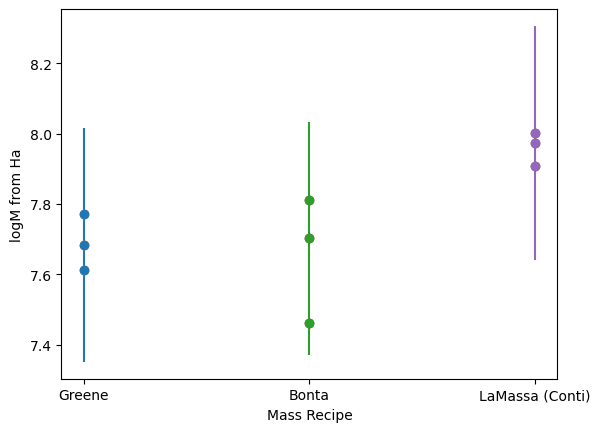

[7.61139376 7.77187316 7.68318565 7.46225109 7.81110014 7.70208005
 7.90729065 8.00035346 7.97372812]
7.462251091871686
8.000353461806414


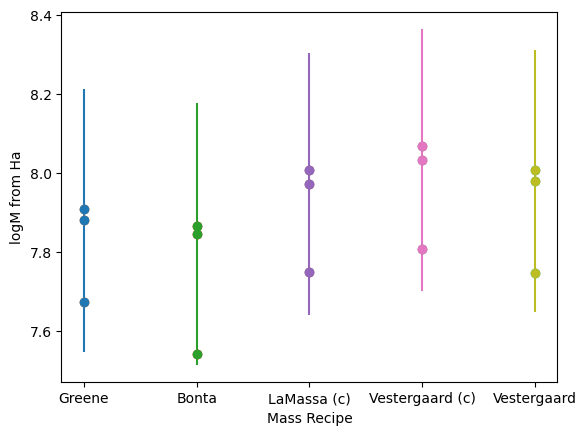

[7.67377442 7.87917986 7.90798281 7.54149266 7.84530793 7.86478192
 7.7478295  7.97232182 8.00708751 7.8078295  8.03232182 8.06708751
 7.74501365 7.97896944 8.00768378]
7.541492657129661
8.06708750598079


In [29]:
'''
count = 0

for i in range(10): # plot masses for every model
    plt.plot([count,count,count], [masses[3*count][2],masses[3*count +1][2],masses[3*count +2][2]], linestyle='None', marker='o')
    count+=1

for i in range(3): # plot line to show epochs
    x = np.arange(0,10)
    plt.plot(x, [masses[0+i][2], masses[2+i][2], masses[5+i][2], masses[8+i][2], masses[11+i][2], 
                 masses[14+i][2], masses[17+i][2], masses[20+i][2], masses[23+i][2], masses[26+i][2]], marker='None', label=i)

plt.legend()
plt.ylabel('logM')
plt.xlabel('Mass Recipe')
plt.show()
'''

# Plot Ha
count = 0
for i in range(3): # plot masses for every model
    plt.errorbar([count,count,count], [masses_Ha[3*count],masses_Ha[3*count +1],masses_Ha[3*count +2]], yerr=[0,0,0.332], linestyle='None', marker='o')
    plt.plot([count,count,count], [masses_Ha[3*count],masses_Ha[3*count +1],masses_Ha[3*count +2]], linestyle='None', marker='o')
    count+=1

plt.xticks([0,1,2],['Greene', 'Bonta', 'LaMassa (Conti)'])
plt.ylabel('logM from Ha')
plt.xlabel('Mass Recipe')
plt.show()

print(masses_Ha)
print(min(masses_Ha))
print(max(masses_Ha))

# Plot Hb
count = 0
for i in range(5): # plot masses for every model
    plt.errorbar([count,count,count], [masses_Hb[3*count],masses_Hb[3*count +1],masses_Hb[3*count +2]], yerr=[0,0.332,0], linestyle='None', marker='o')
    plt.plot([count,count,count], [masses_Hb[3*count],masses_Hb[3*count +1],masses_Hb[3*count +2]], linestyle='None', marker='o')
    count+=1

plt.xticks([0,1,2,3,4],['Greene', 'Bonta', 'LaMassa (c)', 'Vestergaard (c)', 'Vestergaard']) # (c) for L5100 continuum
plt.ylabel('logM from Ha')
plt.xlabel('Mass Recipe')
plt.show()

print(masses_Hb)
print(min(masses_Hb))
print(max(masses_Hb))

In [30]:
print(10**7.462251091871686)
print(10**7.702080054544674) # 2024 Bonta Ha mass
print(10**7.8111001377526925)
print((10**7.702080054544674 + 10**7.8111001377526925 + 10**7.462251091871686)/3)

28990192.013710577
50359342.88187316
64729184.831204616
48026239.90892946


## Bonta Mass Uncertainty

In [31]:
logM_04_err = np.sqrt( (0.03)**2 + (0.812*(1/(np.log(10)*LHa_br_04))*LHa_br_04_err)**2 + (1.634*(1/(np.log(10)*line_params_04.loc['Ha_br', 'fwhm']))*line_params_04.loc['Ha_br', 'fwhm_std'])**2 )
logM_22_err = np.sqrt( (0.03)**2 + (0.812*(1/(np.log(10)*LHa_br_22))*LHa_br_22_err)**2 + (1.634*(1/(np.log(10)*line_params_22.loc['Ha_br', 'fwhm']))*line_params_22.loc['Ha_br', 'fwhm_std'])**2 )
logM_24_err = np.sqrt( (0.03)**2 + (0.812*(1/(np.log(10)*LHa_br_24))*LHa_br_24_err)**2 + (1.634*(1/(np.log(10)*line_params_24.loc['Ha_br', 'fwhm']))*line_params_24.loc['Ha_br', 'fwhm_std'])**2 )

logM_24 = [7.702080054544674, logM_24_err]

vals = np.zeros(10000)
for i in range(10000):
    vals[i] = 10**random.gauss(logM_24[0], logM_24[1])
M_24 = [(np.mean(vals)), (np.std(vals))]
print('Bonta Ha 2024 Mass: ', str(np.mean(vals)), '+-', str(np.std(vals)))

Bonta Ha 2024 Mass:  50535779.28282809 +- 3742325.582436277


In [32]:
M_24

[50535779.28282809, 3742325.582436277]

## Black Hole Mass Plot (Ha Bonta+24)

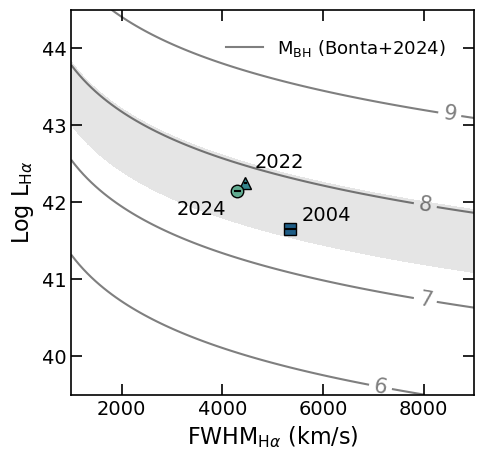

In [57]:
# Bonta 2024 Ha Model (default takes logL)
def B24_Ha(logLum, Wid):
    a = 7.37
    b = 42
    c = 0.812
    d = 3.5
    e = 1.634
    return a + c*(logLum - b) + e*(np.log10(Wid) - d)

#def B24_Ha_Error():

# Bonta 2020 Hb Model (default takes logL)
def B20_Hb(logLum, Wid):
    a = 7.37
    b = 42
    c = 0.812
    d = 3.5
    e = 1.387
    return a + c*(logLum - b) + e*(np.log10(Wid) - d)

# Bonta et al. 2024 Ha Mass Contour
# Create Width and Luminosity values
x = np.linspace(1000, 9000, 100) # FWHM
y = np.linspace(39.5, 44.5, 100) # LogLuminosity
X, Y = np.meshgrid(x, y)
Z = B24_Ha(Y, X)

# Plot
fig, ax = plt.subplots(figsize=(5.2,5))

# Create contours
B24_Ha_24 = B24_Ha(np.log10(LHa_br_24), line_params_24.at['Ha_br','fwhm'])
shaded_region = ax.contourf(X, Y, Z, levels=[B24_Ha_24-0.332, B24_Ha_24+0.332], colors='grey', alpha=0.2) # shade single epoch scatter associated with 
labelC = ax.contour(X, Y, Z, [6,7,8,9], alpha=0.5, colors=['black','black','black','black']) # contours to label
#C = ax.contour(X, Y, Z, [6.5,7.5,8.5], alpha=0.5, linestyles='--')
ax.clabel(labelC, fontsize=15)
ax.plot([1000,1011], [1,2], marker='None', linestyle='-', color='black', alpha=0.5, label=r'M$_{\text{BH}}$ (Bonta+2024)') # create legend label

# Plot data
ax.plot(line_params_04.at['Ha_br','fwhm'], np.log10(LHa_br_04), linestyle='None', marker='s', markersize=9, color=colors[2], markeredgecolor='black', zorder=3)
ax.errorbar(line_params_04.at['Ha_br','fwhm'], np.log10(LHa_br_04), yerr=(1/np.log(10))*LHa_br_04_err/LHa_br_04, xerr=line_params_04.at['Ha_br','fwhm_std'], linestyle='None', color='black', elinewidth=1.5, zorder=3)
ax.plot(line_params_22.at['Ha_br','fwhm'], np.log10(LHa_br_22), linestyle='None', marker='^', markersize=9, color=colors[1], markeredgecolor='black', zorder=3)
ax.errorbar(line_params_22.at['Ha_br','fwhm'], np.log10(LHa_br_22), yerr=(1/np.log(10))*LHa_br_22_err/LHa_br_22, xerr=line_params_22.at['Ha_br','fwhm_std'], linestyle='None', color='black', elinewidth=1.5, zorder=3)
ax.plot(line_params_24.at['Ha_br','fwhm'], np.log10(LHa_br_24), linestyle='None', marker='o', markersize=9, color=colors[0], markeredgecolor='black', zorder=3)
ax.errorbar(line_params_24.at['Ha_br','fwhm'], np.log10(LHa_br_24), yerr=(1/np.log(10))*LHa_br_24_err/LHa_br_24, xerr=line_params_24.at['Ha_br','fwhm_std'], linestyle='None', color='black', elinewidth=1.5, zorder=3)

# Label data
ax.text(line_params_04.at['Ha_br','fwhm'] + 220, np.log10(LHa_br_04) + 0.1, '2004', fontsize=14)
ax.text(line_params_22.at['Ha_br','fwhm'] + 180, np.log10(LHa_br_22) + 0.2, '2022', fontsize=14)
ax.text(line_params_24.at['Ha_br','fwhm'] - 1200, np.log10(LHa_br_24) - 0.3, '2024', fontsize=14)

# Axis labels
#ax.set_title('Bonta et al. 2024', fontsize=16)
ax.set_xlabel(r'FWHM$_{\text{H} \alpha }$ (km/s)', fontsize=16)
ax.set_ylabel(r'Log L$_{\text{H} \alpha }$', fontsize=16)

# Axis customization
'''
ax.tick_params(labelsize=15)
ax.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=16, size=6, width=1.5)
ax.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=16, size=3, width=1.2)
'''

ax.set_xticks([2000,4000,6000,8000])
ax.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
#ax.minorticks_on()
ax.spines['left'].set_linewidth(1.2)
ax.spines['top'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
ax.set_xlim(1000, 9000)
ax.set_ylim(39.5, 44.5)

ax.legend(frameon=False, bbox_to_anchor=(0.97,0.97), fontsize=13)

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "B24_HA_BHMass_Contour_for_paper.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()

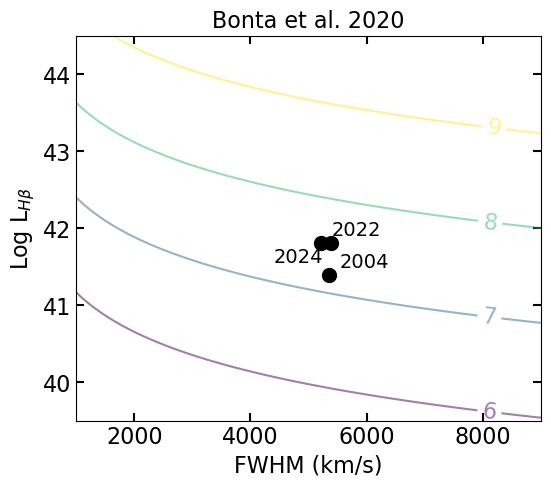

In [106]:
# Bonta et al. 2020 Hb Mass Contour
# Create Width and Luminosity values
x = np.linspace(1000, 9000, 100) # FWHM
y = np.linspace(39.5, 44.5, 100) # LogLuminosity
X, Y = np.meshgrid(x, y)
Z = B20_Hb(Y, X)

# Plot
fig, ax = plt.subplots(figsize=(6,5))

# Create contours
labelC = ax.contour(X, Y, Z, [6,7,8,9], alpha=0.5) # contours to label
#C = ax.contour(X, Y, Z, [6.5,7.5,8.5], alpha=0.5, linestyles='--')
ax.clabel(labelC, fontsize=16)

# Plot data
ax.plot(line_params_04.at['Hb_br','fwhm'], np.log10(LHb_br_04), linestyle='None', marker='o', markersize=10, color='black', zorder=3)
ax.plot(line_params_22.at['Hb_br','fwhm'], np.log10(LHb_br_22), linestyle='None', marker='o', markersize=10, color='black', zorder=3)
ax.plot(line_params_24.at['Hb_br','fwhm'], np.log10(LHb_br_24), linestyle='None', marker='o', markersize=10, color='black', zorder=3)

# Label data
ax.text(line_params_04.at['Hb_br','fwhm'] + 180, np.log10(LHb_br_04) + 0.1, '2004', fontsize=14)
ax.text(line_params_22.at['Hb_br','fwhm'] + 180, np.log10(LHb_br_22) + 0.1, '2022', fontsize=14)
ax.text(line_params_24.at['Hb_br','fwhm'] - 1000, np.log10(LHb_br_24) - 0.25, '2024', fontsize=14)

# Axis labels
ax.set_title('Bonta et al. 2020', fontsize=16)
ax.set_xlabel(r'FWHM (km/s)', fontsize=16)
ax.set_ylabel(r'Log L$_{H \beta }$', fontsize=16)

# Axis customization
ax.tick_params(labelsize=15)
ax.tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=16, size=6, width=1.5)
ax.tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=16, size=3, width=1.2)

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "B24_HAB_BHMass_Contour.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
plt.show()

In [107]:
# Mass value estimates
B24_Ha_04 = 10**B24_Ha(np.log10(LHa_br_04), line_params_04.at['Ha_br','fwhm'])
B24_Ha_22 = 10**B24_Ha(np.log10(LHa_br_22), line_params_22.at['Ha_br','fwhm'])
B24_Ha_24 = 10**B24_Ha(np.log10(LHa_br_24), line_params_24.at['Ha_br','fwhm'])


print('Mass values using HA emission and Bonta et al. 2024')
print('2004: ', str("{:.1e}".format(B24_Ha_04)) + r' M_sun')
print('2022: ', str("{:.1e}".format(B24_Ha_22)) + r' M_sun')
print('2024: ', str("{:.1e}".format(B24_Ha_24)) + r' M_sun')
print('Average Mass Value: ', str("{:.3e}".format(np.mean([B24_Ha_04,B24_Ha_22,B24_Ha_24]))) + r' M_sun')

Mass values using HA emission and Bonta et al. 2024
2004:  2.9e+07 M_sun
2022:  6.5e+07 M_sun
2024:  5.0e+07 M_sun
Average Mass Value:  4.803e+07 M_sun


# Balmer Decrements

In [108]:
# Narrow decrements
HaHb_na_04 = line_params_04.at['Ha_na', 'area']/line_params_04.at['Hb_na', 'area']
HaHb_na_22 = line_params_22.at['Ha_na', 'area']/line_params_22.at['Hb_na', 'area']
HaHb_na_24 = line_params_24.at['Ha_na', 'area']/line_params_24.at['Hb_na', 'area']

# Broad decrements
HaHb_br_04 = line_params_04.at['Ha_br', 'area']/line_params_04.at['Hb_br', 'area']
HaHb_br_22 = line_params_22.at['Ha_br', 'area']/line_params_22.at['Hb_br', 'area']
HaHb_br_24 = line_params_24.at['Ha_br', 'area']/line_params_24.at['Hb_br', 'area']


data = np.array([[HaHb_na_04, HaHb_na_22, HaHb_na_24],  # Narrow Ha/Hb values
        [HaHb_br_04, HaHb_br_22, HaHb_br_24]])  # Broad Ha/Hb values

df = pd.DataFrame(data, index=['Narrow Ha/Hb', 'Broad Ha/Hb'], columns=[2004, 2022, 2024])
log_df = pd.DataFrame(np.log10(data), index=['Narrow log Ha/Hb', 'Broad log Ha/Hb'], columns=[2004, 2022, 2024])

print(df)
print(log_df)

def calcDecrement(df, line):
    flux_ratio = df.at[line, 'area']/df.at['Hb_br', 'area']
    flux_ratio_err = flux_ratio * np.sqrt( (df.at[line, 'area_std']/df.at[line, 'area'])**2 + (df.at['Hb_br', 'area_std']/df.at['Hb_br', 'area'])**2 )
    return flux_ratio, flux_ratio_err

print('')
print('Broad Flux Ratios for 2004')
print('F_Ha / F_Hb', str(calcDecrement(line_params_04, 'Ha_br')))
print('F_Hg / F_Hb', str(calcDecrement(line_params_04, 'Hg_br')))
print('F_Hd / F_Hb', str(calcDecrement(line_params_04, 'Hd_br')))
print('F_Hep/ F_Hb', str(calcDecrement(line_params_04, 'Hep_br')))
#print('F_Hb', str(line_params_04.at['Hb_br', 'area'], line_params_04.at['Hb_br', 'area_std']))
print('')
print('Broad Flux Ratios for 2022')
print('F_Ha / F_Hb', str(calcDecrement(line_params_22, 'Ha_br')))
print('F_Hg / F_Hb', str(calcDecrement(line_params_22, 'Hg_br')))
print('F_Hd / F_Hb', str(calcDecrement(line_params_22, 'Hd_br')))
print('F_Hep/ F_Hb', str(calcDecrement(line_params_22, 'Hep_br')))
#print('F_Hb', str(line_params_22.at['Hb_br', 'area'], line_params_04.at['Hb_br', 'area_std']))
print('')
print('Broad Flux Ratios for 2024')
print('F_Ha / F_Hb', str(calcDecrement(line_params_24, 'Ha_br')))
print('F_Hg / F_Hb', str(calcDecrement(line_params_24, 'Hg_br')))
print('F_Hd / F_Hb', str(calcDecrement(line_params_24, 'Hd_br')))
print('F_Hep/ F_Hb', str(calcDecrement(line_params_24, 'Hep_br')))
#print('F_Hb', str(line_params_24.at['Hb_br', 'area'], line_params_04.at['Hb_br', 'area_std']))

                  2004      2022      2024
Narrow Ha/Hb  3.308486  4.752652  3.064974
Broad Ha/Hb   1.820550  2.766921  2.189464
                      2004      2022      2024
Narrow log Ha/Hb  0.519629  0.676936  0.486427
Broad log Ha/Hb   0.260203  0.441997  0.340338

Broad Flux Ratios for 2004
F_Ha / F_Hb (1.8205504503981296, 0.11929322503429542)
F_Hg / F_Hb (0.07766290527689562, 0.037394219663135046)
F_Hd / F_Hb (0.11905371880563612, 0.03738805023061545)
F_Hep/ F_Hb (0.007029498739826662, 0.013161707525546584)

Broad Flux Ratios for 2022
F_Ha / F_Hb (2.766920791603832, 0.033893688187326104)
F_Hg / F_Hb (0.4511059678250003, 0.009749195309800455)
F_Hd / F_Hb (0.19515090057795254, 0.008149706457617764)
F_Hep/ F_Hb (0.06383367325828597, 0.009887022760653744)

Broad Flux Ratios for 2024
F_Ha / F_Hb (2.1894635542380723, 0.13954218835965182)
F_Hg / F_Hb (0.36041612957710367, 0.038634975178938845)
F_Hd / F_Hb (0.24376355272079317, 0.040163161856485746)
F_Hep/ F_Hb (0.038744230473812605, 0.

# Line Variability

From Zeltyn+2024 who distinguish extremely variable quasars (EVQs) apart from CLAGN by ensuring:
max[C(line)] > 2

Where: C(line) = F2/F1 - delta(F2/F1)

In [109]:
# First term is ratio between flux of line in both epochs
# Second term is the propagated error in this ratio (1 sigma)
C_Ha = (line_params_22.at['Ha_br', 'area']/line_params_04.at['Ha_br', 'area'] - 
        (line_params_22.at['Ha_br', 'area']/line_params_04.at['Ha_br', 'area'])*np.sqrt(
            (line_params_22.at['Ha_br', 'area_std']/line_params_22.at['Ha_br', 'area'])**2 + (line_params_04.at['Ha_br', 'area_std']/line_params_04.at['Ha_br', 'area'])**2
            )
        )
C_Hb = (line_params_22.at['Hb_br', 'area']/line_params_04.at['Hb_br', 'area'] - 
        (line_params_22.at['Hb_br', 'area']/line_params_04.at['Hb_br', 'area'])*np.sqrt(
            (line_params_22.at['Hb_br', 'area_std']/line_params_22.at['Hb_br', 'area'])**2 + (line_params_04.at['Hb_br', 'area_std']/line_params_04.at['Hb_br', 'area'])**2
            )
        )
print('Automatic selection criteria used to distinguish CLAGN from extremely variable Quasars C>2 for any line:')
print('2004-2022, C(Ha) = ' ,str(C_Ha))
print('2004-2022, C(Hb) = ' ,str(C_Hb))

Automatic selection criteria used to distinguish CLAGN from extremely variable Quasars C>2 for any line:
2004-2022, C(Ha) =  3.803504514736252
2004-2022, C(Hb) =  2.396447028509704


# Broad Line Region Analysis

Popovic 2003 and corrected via Erratum 2006 for value of const. A

log(I_n) = log(I_ul x λ / g_u x A_ul) = B - A x E_u

I_ul = measured flux (intensity of upper to lower transition)

λ = transition wavelength

g_u = 2n^2 - statistical weight of transition

A_ul = Einstein coefficients


A = log(e) / kT ~ 0.4323/kT, where k = 8.6173x10^-5 eV/K is Boltzmann's const (in eV/K)

In [110]:
# Atomic transition intensity for Balmer lines
def intensityEquation(I_ul, I_ul_std, wavelength, g_u, A_ul):
    logIntensity = np.log10((I_ul*wavelength) / (g_u * A_ul))
    logIntensity_err = 1/(np.log(10)*I_ul) * I_ul_std
    return logIntensity, logIntensity_err

Ha_04_flux_mean = line_params_04.at['Ha_na', 'area']
Ha_04_flux_std = line_params_04.at['Ha_na', 'area_std']

'''
# Reproduce Akn 564 values from paper
logI_Akn = np.zeros(5, dtype=float)
logI_Akn_err = np.zeros(5, dtype=float)
logI_Akn[0], logI_Akn_err[0] = intensityEquation(3.78,0.53,6562.8, 18, 4.41e7)
logI_Akn[1], logI_Akn_err[1] = intensityEquation(1.00,0.10,4861.33, 32, 8.41e6)
logI_Akn[2], logI_Akn_err[2] = intensityEquation(0.35,0.06,4340.47, 50, 2.53e6)
logI_Akn[3], logI_Akn_err[3] = intensityEquation(0.20,0.03,4101.74, 72, 1.05e6)
logI_Akn[4], logI_Akn_err[4] = intensityEquation(0.20,0.02,3970.07, 98, 5.33e5)
'''

# 2022 BP
logI = np.zeros(5, dtype=float)
logI_err = np.zeros(5, dtype=float)
logI[0], logI_err[0] = intensityEquation(line_params_22.at['Ha_br', 'area']*10**(-17),
                                         line_params_22.at['Ha_br', 'area_std']*10**(-17),
                                         6562.8, 18, 4.41e7)
logI[1], logI_err[1] = intensityEquation(line_params_22.at['Hb_br', 'area']*10**(-17),
                                         line_params_22.at['Hb_br', 'area_std']*10**(-17),
                                         4861.33, 32, 8.41e6)
logI[2], logI_err[2] = intensityEquation(line_params_22.at['Hg_br', 'area']*10**(-17),
                                         line_params_22.at['Hg_br', 'area_std']*10**(-17),
                                         4340.47, 50, 2.53e6)
logI[3], logI_err[3] = intensityEquation(line_params_22.at['Hd_br', 'area']*10**(-17),
                                         line_params_22.at['Hd_br', 'area_std']*10**(-17),
                                         4101.74, 72, 1.05e6)
logI[4], logI_err[4] = intensityEquation(line_params_22.at['Hep_br', 'area']*10**(-17),
                                         line_params_22.at['Hep_br', 'area_std']*10**(-17),
                                         3970.07, 98, 5.33e5)

# 2024
logI_24 = np.zeros(5, dtype=float)
logI_err_24 = np.zeros(5, dtype=float)
logI_24[0], logI_err_24[0] = intensityEquation(line_params_24.at['Ha_br', 'area']*10**(-17),
                                               line_params_24.at['Ha_br', 'area_std']*10**(-17),
                                               6562.8, 18, 4.41e7)
logI_24[1], logI_err_24[1] = intensityEquation(line_params_24.at['Hb_br', 'area']*10**(-17),
                                               line_params_24.at['Hb_br', 'area_std']*10**(-17),
                                               4861.33, 32, 8.41e6)
logI_24[2], logI_err_24[2] = intensityEquation(line_params_24.at['Hg_br', 'area']*10**(-17),
                                               line_params_24.at['Hg_br', 'area_std']*10**(-17),
                                               4340.47, 50, 2.53e6)
logI_24[3], logI_err_24[3] = intensityEquation(line_params_24.at['Hd_br', 'area']*10**(-17),
                                               line_params_24.at['Hd_br', 'area_std']*10**(-17),
                                               4101.74, 72, 1.05e6)
logI_24[4], logI_err_24[4] = intensityEquation(line_params_24.at['Hep_br', 'area']*10**(-17),
                                               line_params_24.at['Hep_br', 'area_std']*10**(-17),
                                               3970.07, 98, 5.33e5)

# 2004
logI_04 = np.zeros(5, dtype=float)
logI_err_04 = np.zeros(5, dtype=float)
logI_04[0], logI_err_04[0] = intensityEquation(line_params_04.at['Ha_br', 'area']*10**(-17),
                                               line_params_04.at['Ha_br', 'area_std']*10**(-17),
                                               6562.8, 18, 4.41e7)
logI_04[1], logI_err_04[1] = intensityEquation(line_params_04.at['Hb_br', 'area']*10**(-17),
                                               line_params_04.at['Hb_br', 'area_std']*10**(-17),
                                               4861.33, 32, 8.41e6)
logI_04[2], logI_err_04[2] = intensityEquation(line_params_04.at['Hg_br', 'area']*10**(-17),
                                               line_params_04.at['Hg_br', 'area_std']*10**(-17),
                                               4340.47, 50, 2.53e6)
logI_04[3], logI_err_04[3] = intensityEquation(line_params_04.at['Hd_br', 'area']*10**(-17),
                                               line_params_04.at['Hd_br', 'area_std']*10**(-17),
                                               4101.74, 72, 1.05e6)
logI_04[4], logI_err_04[4] = intensityEquation(line_params_04.at['Hep_br', 'area']*10**(-17),
                                               line_params_04.at['Hep_br', 'area_std']*10**(-17),
                                               3970.07, 98, 5.33e5)

# Balmer energy levels E_3,4,5,6,7 (Ha, Hb, Hg, Hd. Hep) in eV
E_u = np.array([12.088, 12.748, 13.054, 13.218, 13.322])

# Function defining the linear fit
def linearFunc(x,intercept,slope):
    y = intercept + slope * x
    return y

11838.793741487898 928.531972230548
11903.421967320784 2411.280693996623
Gradient 2022:  -0.4257019548239702 +- 0.033388357321395674
Gradient 2024:  -0.4233906562621453 +- 0.08576640551483854
Temp 2022, T =  11839.0 ± 929.0 K
Temp 2024, T =  11903.0 ± 2411.0 K


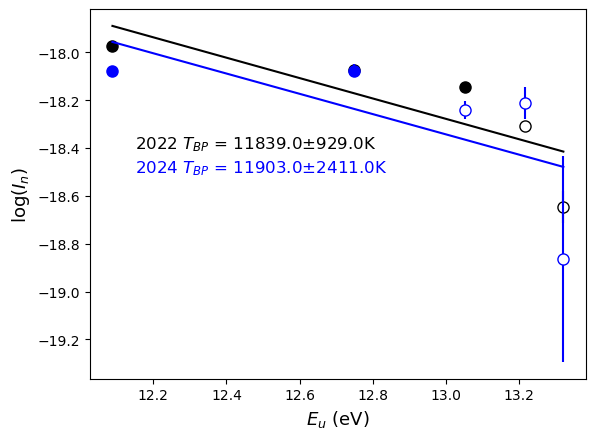

In [114]:
def bestFitLine(linearFunc, x, y, y_err=None, sigma=False, col='black'):
    if y_err is None: 
        fit, cov = curve_fit(linearFunc, x, y)
    else:
        fit, cov = curve_fit(linearFunc, x, y, sigma=y_err, absolute_sigma=sigma)
    inter, slope = fit
    inter_err, slope_err = np.diag(cov)
    
    # calc temperature from slope
    T, T_err = calcBPTemp(slope, slope_err)
    
    if T < 10000:
        plt.plot(x, slope*x + inter, marker='None', color='red')
    else:
        plt.plot(x, slope*x + inter, marker='None', color=col)
    print(T, T_err)
    return inter, inter_err, slope, slope_err

def calcBPTemp(slope, slope_err):
    T = np.log10(np.e)/((8.6173e-5)*(-1*slope))
    T_err = np.log10(np.e)/(8.6173e-5) * (slope)**(-2) * slope_err
    return T, T_err
    
    

# Linear regression of 2022
#fit_22, cov_22 = curve_fit(linearFunc, E_u, logI, sigma=logI_err, absolute_sigma=True) # not fitting Ha
#inter_22, slope_22 = fit_22
#inter_err_22, slope_err_22 = np.diag(cov_22)
#plt.plot(E_u, slope_22*E_u + inter_22, marker='None', color='black')

# Plot 2022 data
plt.errorbar(E_u, logI, yerr=logI_err, linestyle='None', color='black')
plt.plot(E_u, logI, marker='o', linestyle='None', markersize=8, color='black', label='2022')
plt.plot(E_u[3:], logI[3:], marker='o', linestyle='None', markersize=6, color='white')
# Plot 2024 data
plt.errorbar(E_u, logI_24, yerr=logI_err_24, linestyle='None', color='blue')
plt.plot(E_u, logI_24, marker='o', linestyle='None', markersize=8, color='blue', label='2024')
plt.plot(E_u[2:], logI_24[2:], marker='o', linestyle='None', markersize=6, color='white')

# Linear regression
#inter_22, inter_err_22, slope_22, slope_err_22 = bestFitLine(linearFunc, E_u, logI, logI_err, True)
inter_22, inter_err_22, slope_22, slope_err_22 = bestFitLine(linearFunc, E_u, logI)
inter_24, inter_err_24, slope_24, slope_err_24 = bestFitLine(linearFunc, E_u, logI_24, col='blue')
#inter_22, inter_err_22, slope_22, slope_err_22 = bestFitLine(linearFunc, E_u[:-1], logI[:-1])
#inter_24, inter_err_24, slope_24, slope_err_24 = bestFitLine(linearFunc, E_u[:-1], logI_24[:-1], col='blue')

print('Gradient 2022: ', str(slope_22), '+-', str(slope_err_22))
print('Gradient 2024: ', str(slope_24), '+-', str(slope_err_24))



# Calculate the temperature
T_22 = np.log10(np.e)/((8.6173e-5)*(-1*slope_22))
T_err_22 = np.log10(np.e)/(8.6173e-5) * (slope_22)**(-2) * slope_err_22
print('Temp 2022, T = ', str(np.round(T_22)), '±', str(np.round(T_err_22)), 'K')
T_24 = np.log10(np.e)/((8.6173e-5)*(-1*slope_24))
T_err_24 = np.log10(np.e)/(8.6173e-5) * (slope_24)**(-2) * slope_err_24
print('Temp 2024, T = ', str(np.round(T_24)), '±', str(np.round(T_err_24)), 'K')

# Add text to plot
plt.text(12.15, -18.4, r'2022 $T_{BP}$ = '+ str(np.round(T_22))+'±'+str(np.round(T_err_22))+'K', color='black', fontsize=12)
plt.text(12.15, -18.5, r'2024 $T_{BP}$ = '+ str(np.round(T_24))+'±'+str(np.round(T_err_24))+'K', color='blue', fontsize=12)

plt.ylabel(r'log($I_{n}$)', fontsize=13)
plt.xlabel(r'$E_{u}$ (eV)', fontsize=13)
#plt.legend()
plt.show()

In [115]:
logI[:3]

array([-17.97310303, -18.0756687 , -18.14275302])

## Boltzmann Plots

In [108]:
# Prepare data for SDSS
# Rebin_spec
def rebin_spec(wave, specin, wavnew):
    spec = spectrum.ArraySourceSpectrum(wave=wave, flux=specin)
    f = np.ones(len(wave))
    filt = spectrum.ArraySpectralElement(wave, f, waveunits='angstrom')
    obs = observation.Observation(spec, filt, binset=wavnew, force='taper')
    return obs.binflux

# Function that reads in the data from txt. files
def readTxt(file_path, errors):
    # Initialize empty lists to be returned
    values1 = []
    values2 = []
    err_values = []
    
    with open(file_path, 'r') as file:
        for line in file:
            
            # Check the row begins with a number - not holding a column title
            if line[0].isnumeric():
            
                # Split each line into separate values separated by one or more space or commas
                values = re.split(r'[\s,]+', line.strip())
                
                # Convert the values to floats and append them to the respective lists
                if len(values) > 1:
                    values1.append(float(values[0]))
                    values2.append(float(values[1]))
                    if errors == True:
                        err_values.append(abs(float(values[2])))
    
    if errors == True:
        return(np.array(values1), np.array(values2), np.array(err_values))
    else:
        return(np.array(values1), np.array(values2))

# Function calculating rest frame wavelength from host redshift
def restFrameWavelength(obs_wavelength, redshift): # takes list of measured wavelengths
    rest_wavelength = []
    for n in range(len(obs_wavelength)):
        rest_wavelength.append(obs_wavelength[n]/(redshift+1))
    return(np.array(rest_wavelength))

# Function that converts spectral wavelength into upper transition energy level (no physical meaning apart from at discrete Balmer transitions - only representative for rest of spectrum)
def convertToEnergyLevels(wavelengths, flux):
    # Known Balmer lines with their excitation energies (from n → 2)
    balmer_lines = {
        6563: 12.088,  # Hα (3 → 2)
        4861: 12.75,   # Hβ (4 → 2)
        4340: 13.056,  # Hγ (5 → 2)
        4102: 13.222,  # Hδ (6 → 2)
        3970: 13.322,  # Hε (7 → 2)
    }
    
    # Sort keys for interpolation
    known_wavelengths = np.array(sorted(balmer_lines.keys()))
    known_energies = np.array([balmer_lines[wl] for wl in known_wavelengths])
    
    # Interpolate: wavelength → excitation energy
    lambda_to_energy = interp1d(
        known_wavelengths,
        known_energies,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'  # enables slight extrapolation
    )
    
    # Apply mapping to full spectrum
    energy_axis = lambda_to_energy(wavelengths)
    
    # Filter to valid (interpolated) energies
    valid = ~np.isnan(energy_axis)
    energy_axis_valid = energy_axis[valid]
    flux_valid = flux[valid]
    return(energy_axis_valid, flux_valid)

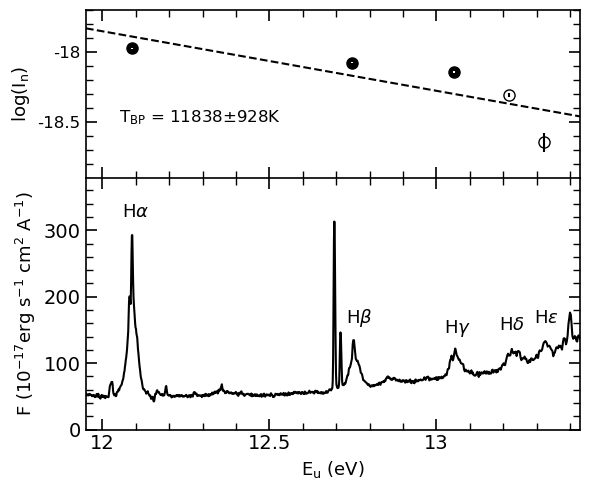

-0.4257019548239702

In [109]:
# 2022
file_path_2022 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr4_2022-09-09T05h46h03s_final_red.txt'
wave, flux, err = readTxt(file_path_2022, True)
z = 0.074550  # Redshift

flux = flux * 2.8414225252601 * 1e17
err = err * 2.8414225252601 * 1e17
lam = wave


indices_to_remove = np.where((lam > 5271) & (lam < 5283))[0] # cut noise section
flux = np.delete(flux, indices_to_remove)
err = np.delete(err, indices_to_remove)
lam = np.delete(wave, indices_to_remove)

lam = restFrameWavelength(lam, 0.074550)

upper_trans_energy_22, flux_22 = convertToEnergyLevels(lam, flux)

#f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 3]})
fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [2, 3]}) # was 14,5 with 3 plots

# Plot Data
ax[0].plot(E_u, logI, marker='o', linestyle='None', markersize=8, color='black', label='2022 Data')
ax[0].plot(E_u[3:], logI[3:], marker='o', linestyle='None', markersize=6, color='white') # make low snr points hollow by plotting smaller white circle on top
ax[0].errorbar(E_u[:3], logI[:3], yerr=logI_err[:3], linestyle='None', color='white')
ax[0].errorbar(E_u[3:], logI[3:], yerr=logI_err[3:], linestyle='None', color='black') # change colour of error bars to show over the existing points
ax[0].plot(np.array([11,14]), slope_22*np.array([11,14]) + inter_22, marker='None', linestyle='--', color='black') # best fit without error consideration
#ax[0].set_ylim(-18.7, -17.7)
ax[0].set_ylim(-18.9, -17.7)
ax[0].set_ylabel(r'log(I$_{\text{n}}$)', fontsize=13)

ax[1].plot(upper_trans_energy_22, flux_22, color='black')
#ax[1].set_xlim(11.95, 13.38)
ax[1].set_xlim(11.95, 13.43)
ax[1].set_ylim(0, 379)
ax[1].set_ylabel(r'F ($10^{-17}$erg s$^{-1}$ cm$^{2}$ A$^{-1}$)', fontsize=13)
ax[1].set_xlabel(r'E$_{\text{u}}$ (eV)', fontsize=13)

# Axis customization
ax[0].set_yticks([-18.5, -18], ['-18.5','-18'])
ax[1].set_yticks([0,100,200,300], ['0','100','200','300'])
ax[1].set_xticks([12,12.5,13], ['12','12.5','13'])
ax[0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=12, size=8, width=1.2)
ax[1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax[0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].spines['left'].set_linewidth(1.2)
ax[0].spines['top'].set_linewidth(1.2)
ax[0].spines['right'].set_linewidth(1.2)
ax[1].spines['left'].set_linewidth(1.2)
ax[1].spines['right'].set_linewidth(1.2)
ax[1].spines['bottom'].set_linewidth(1.2)
ax[1].spines['top'].set_linewidth(1.2)

# Add text to plot
ax[0].text(12.05, -18.5, r'T$_{\text{BP}}$ = '+str(int(T_22))+'±'+str(int(T_err_22))+'K', fontsize=12)

# Line labels on plot
ax[1].text(E_u[0]-0.03, 320, r'H$\alpha$', fontsize=13)
ax[1].text(E_u[1]-0.02, 160, r'H$\beta$', fontsize=13)
ax[1].text(E_u[2]-0.03, 145, r'H$\gamma$', fontsize=13)
ax[1].text(E_u[3]-0.03, 150, r'H$\delta$', fontsize=13)
ax[1].text(E_u[4]-0.03, 160, r'H$\epsilon$', fontsize=13)

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Adjust the width space between subplots

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "boltzmann_plot_2022_for_paper.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
#plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()
slope_22

NameError: name 'slope_04' is not defined

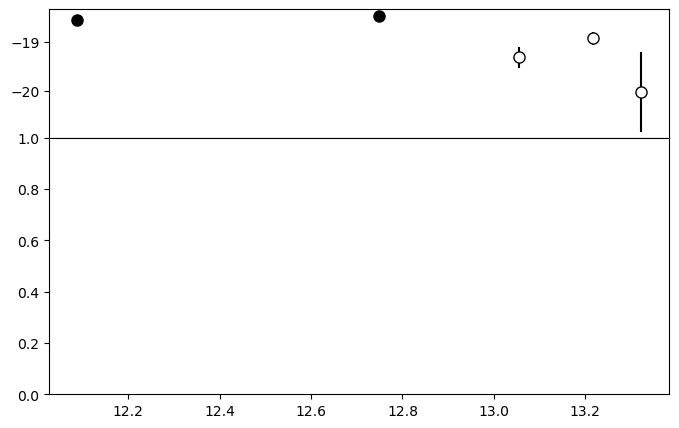

In [110]:
# 2004
# Required
file_path_2004 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/6df_spectra/6dFJ0245455-030450-S-VR-j2009.txt'
wave, flux = readTxt(file_path_2004, False)
err = flux*0.1
z = 0.074550  # Redshift

flux = flux * 0.024643971103449368*3.145 # scale 2022 to 2024 and SDSS units of flux in terms of 1e-17
err = err * 0.024643971103449368*3.145
lam = wave

indices_to_remove = np.where((lam > 5568) & (lam < 5608))[0] # cut noise section
flux = np.delete(flux, indices_to_remove)
err = np.delete(err, indices_to_remove)
lam = np.delete(wave, indices_to_remove)

lam = restFrameWavelength(lam, 0.074550)

upper_trans_energy_04, flux_04 = convertToEnergyLevels(lam, flux)

#f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 3]})
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={'height_ratios': [1.5, 3]}) # was 14,5 with 3 plots
plt.subplots_adjust(hspace=0)  # Adjust the width space between subplots

# Plot Data
ax[0].errorbar(E_u, logI_04, yerr=logI_err_04, linestyle='None', color='black')
ax[0].plot(E_u, logI_04, marker='o', linestyle='None', markersize=8, color='black', label='2004 Data')
ax[0].plot(E_u[2:], logI_04[2:], marker='o', linestyle='None', markersize=6, color='white')
ax[0].plot(E_u, slope_04*E_u + inter_04, marker='None', color='black')
ax[0].set_ylim(-20.6, -17.5)
ax[0].set_ylabel(r'log($I_{n}$)', fontsize=13)

ax[1].plot(upper_trans_energy_04, flux_04, color='black')
ax[1].set_xlim(11.95, 13.38)
ax[1].set_ylim(0, 270)
ax[1].set_ylabel(r'F ($10^{-17}$erg s$^{-1}$ cm$^{2}$ A$^{-1}$)', fontsize=13)
ax[1].set_xlabel(r'Energy ($E_{u}$, eV)', fontsize=13)

# Axis customization
ax[1].set_xticks([12,12.5,13], ['12','12.5','13'])
ax[1].set_yticks([0,100,200], ['0','100','200'])
ax[0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.5)
ax[0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.2)
ax[1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.5)
ax[1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.2)
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].spines['left'].set_linewidth(1.5)
ax[0].spines['top'].set_linewidth(1.5)
ax[0].spines['right'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].spines['right'].set_linewidth(1.5)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['top'].set_linewidth(1.5)

# Line labels on plot
ax[1].text(E_u[0]-0.03, 205, r'H$\alpha$', fontsize=13)
ax[1].text(E_u[1]-0.02, 130, r'H$\beta$', fontsize=13)
ax[1].text(E_u[2]-0.03, 85, r'H$\gamma$', fontsize=13)
ax[1].text(E_u[3]-0.03, 60, r'H$\delta$', fontsize=13)
ax[1].text(E_u[4]-0.03, 60, r'H$\epsilon$', fontsize=13)

plt.show()

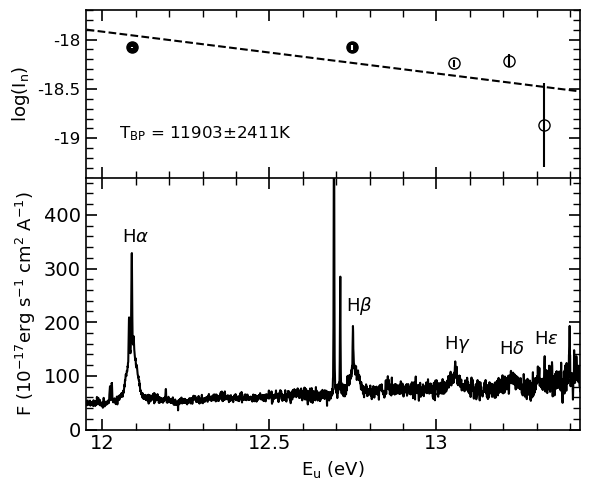

-0.4233906562621453

In [111]:
'''
# 2024
file_path_2024 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/28_August_2024_spec/10JYSElqi_WiFeS_20240828.csv'
wave, flux = readTxt(file_path_2024, False)
err = flux*0.1
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
flux = flux * 1e17 # scale 2022 to 2024 and SDSS units of flux in terms of 1e-17
err = flux*0.1 * 1e17
lam = restFrameWavelength(wave, 0.074550)
'''

rebinned_2024_file = np.load('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/rebinned_2024_for_BP_plot.npz')
lam = rebinned_2024_file['lam']
flux = rebinned_2024_file['flux']

upper_trans_energy_24, flux_24 = convertToEnergyLevels(lam/(1+z), flux)

fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [2, 3]}) # was 14,5 with 3 plots

# Plot Data
ax[0].plot(E_u, logI_24, marker='o', linestyle='None', markersize=8, color='black', label='2024 Data')
ax[0].plot(E_u[2:], logI_24[2:], marker='o', linestyle='None', markersize=6, color='white') # make low snr points hollow by plotting smaller white circle on top
ax[0].errorbar(E_u[:2], logI_24[:2], yerr=logI_err_24[:2], linestyle='None', color='white')
ax[0].errorbar(E_u[2:], logI_24[2:], yerr=logI_err_24[2:], linestyle='None', color='black') # change colour of error bars to show over the existing points
ax[0].plot(np.array([11,14]), slope_24*np.array([11,14]) + inter_24, marker='None', linestyle='--', color='black') # best fit without error consideration
#ax[0].set_ylim(-18.7, -17.7)
ax[0].set_ylim(-19.4, -17.7)
ax[0].set_ylabel(r'log(I$_{\text{n}}$)', fontsize=13)

ax[1].plot(upper_trans_energy_24, flux_24, color='black')
#ax[1].set_xlim(11.95, 13.38)
ax[1].set_xlim(11.95, 13.43)
ax[1].set_ylim(0, 469)
ax[1].set_ylabel(r'F ($10^{-17}$erg s$^{-1}$ cm$^{2}$ A$^{-1}$)', fontsize=13)
ax[1].set_xlabel(r'E$_{\text{u}}$ (eV)', fontsize=13)

# Axis customization
ax[0].set_yticks([-19, -18.5, -18], ['-19', '-18.5','-18'])
ax[1].set_yticks([0,100,200,300,400], ['0','100','200','300','400'])
ax[1].set_xticks([12,12.5,13], ['12','12.5','13'])
ax[0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=12, size=8, width=1.2)
ax[1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax[0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].spines['left'].set_linewidth(1.2)
ax[0].spines['top'].set_linewidth(1.2)
ax[0].spines['right'].set_linewidth(1.2)
ax[1].spines['left'].set_linewidth(1.2)
ax[1].spines['right'].set_linewidth(1.2)
ax[1].spines['bottom'].set_linewidth(1.2)
ax[1].spines['top'].set_linewidth(1.2)

# Add text to plot
ax[0].text(12.05, -19, r'T$_{\text{BP}}$ = '+str(int(T_24))+'±'+str(int(T_err_24))+'K', fontsize=12)

# Line labels on plot
ax[1].text(E_u[0]-0.03, 350, r'H$\alpha$', fontsize=13)
ax[1].text(E_u[1]-0.02, 220, r'H$\beta$', fontsize=13)
ax[1].text(E_u[2]-0.03, 150, r'H$\gamma$', fontsize=13)
ax[1].text(E_u[3]-0.03, 140, r'H$\delta$', fontsize=13)
ax[1].text(E_u[4]-0.03, 160, r'H$\epsilon$', fontsize=13)

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Adjust the width space between subplots

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "boltzmann_plot_2024_for_paper.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
#plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()
slope_24

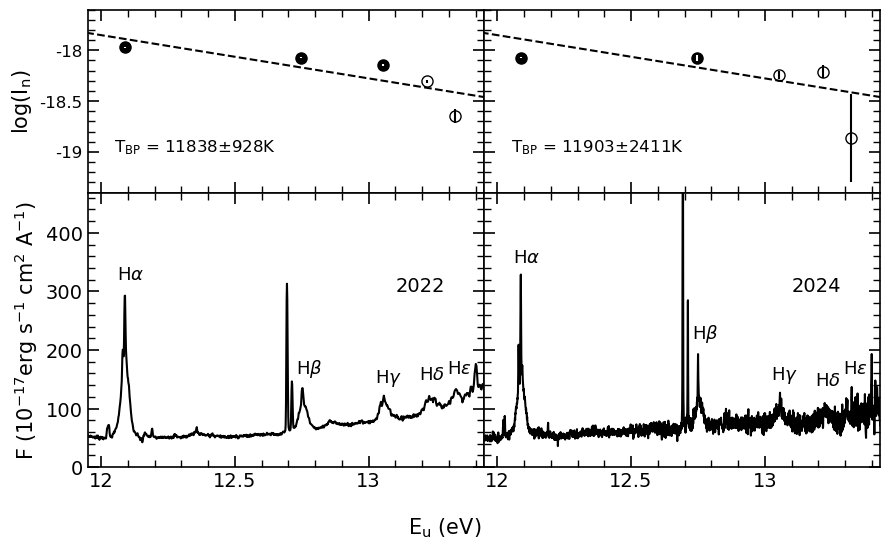

In [117]:
# Create 2x2 subplots with height ratios
fig, ax = plt.subplots(2, 2, sharex=True,gridspec_kw={'height_ratios': [2, 3]},figsize=(9, 5.5))

# Plot 2022 data in first column
ax[0,0].plot(E_u, logI, marker='o', linestyle='None', markersize=8, color='black', label='2022 Data')
ax[0,0].plot(E_u[3:], logI[3:], marker='o', linestyle='None', markersize=6, color='white') # make low snr points hollow by plotting smaller white circle on top
ax[0,0].errorbar(E_u[:3], logI[:3], yerr=logI_err[:3], linestyle='None', color='white')
ax[0,0].errorbar(E_u[3:], logI[3:], yerr=logI_err[3:], linestyle='None', color='black') # change colour of error bars to show over the existing points
ax[0,0].plot(np.array([11,14]), slope_22*np.array([11,14]) + inter_22, marker='None', linestyle='--', color='black')
ax[0,0].set_ylabel(r'log(I$_{\text{n}}$)', fontsize=15)

ax[1,0].plot(upper_trans_energy_22, flux_22, color='black')
ax[1,0].set_ylabel(r'F ($10^{-17}$erg s$^{-1}$ cm$^{2}$ A$^{-1}$)', fontsize=15)
#ax[1,0].set_xlabel(r'E$_{\text{u}}$ (eV)', fontsize=13)

# Plot 2024 data in first column
ax[0,1].plot(E_u, logI_24, marker='o', linestyle='None', markersize=8, color='black', label='2024 Data')
ax[0,1].plot(E_u[2:], logI_24[2:], marker='o', linestyle='None', markersize=6, color='white') # make low snr points hollow by plotting smaller white circle on top
ax[0,1].errorbar(E_u[:2], logI_24[:2], yerr=logI_err_24[:2], linestyle='None', color='white')
ax[0,1].errorbar(E_u[2:], logI_24[2:], yerr=logI_err_24[2:], linestyle='None', color='black') # change colour of error bars to show over the existing points
ax[0,1].plot(np.array([11,14]), slope_22*np.array([11,14]) + inter_22, marker='None', linestyle='--', color='black')

ax[1,1].plot(upper_trans_energy_24, flux_24, color='black')
#ax[1,1].set_xlabel(r'E$_{\text{u}}$ (eV)', fontsize=13)

# Add temperature text to plots
ax[0,0].text(12.05, -19, r'T$_{\text{BP}}$ = '+str(int(T_22))+'±'+str(int(T_err_22))+'K', fontsize=12)
ax[0,1].text(12.05, -19, r'T$_{\text{BP}}$ = '+str(int(T_24))+'±'+str(int(T_err_24))+'K', fontsize=12)

ax[1,0].text(13.1, 300, r'2022', fontsize=14)
ax[1,1].text(13.1, 300, r'2024', fontsize=14)

# Control axis limits (sharex is on but not sharey)
ax[0,0].set_ylim(-19.4, -17.6)
ax[1,0].set_ylim(0, 469)
ax[1,0].set_xlim(11.95, 13.43)
ax[0,1].set_ylim(-19.4, -17.6)
ax[1,1].set_ylim(0, 469)

# Axis customization
ax[0,0].set_yticks([-19, -18.5, -18], ['-19', '-18.5','-18'])
ax[1,0].set_yticks([0,100,200,300,400], ['0','100','200','300','400'])
ax[0,1].set_yticks([-19, -18.5, -18], [])
ax[1,1].set_yticks([0,100,200,300,400], [])
ax[1,0].set_xticks([12,12.5,13], ['12','12.5','13'])
ax[1,1].set_xticks([12,12.5,13], ['12','12.5','13'])
ax[0,0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=12, size=8, width=1.2)
ax[1,0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax[0,0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[1,0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[0,1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=12, size=8, width=1.2)
ax[1,1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax[0,1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[1,1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[0,0].minorticks_on()
ax[1,0].minorticks_on()
ax[0,1].minorticks_on()
ax[1,1].minorticks_on()
ax[0,0].spines['left'].set_linewidth(1.2) # top left
ax[0,0].spines['top'].set_linewidth(1.2)
ax[0,0].spines['right'].set_linewidth(1.2)
ax[0,0].spines['bottom'].set_linewidth(1.2)
ax[1,0].spines['left'].set_linewidth(1.2) # bottom left
ax[1,0].spines['right'].set_linewidth(1.2)
ax[1,0].spines['bottom'].set_linewidth(1.2)
ax[1,0].spines['top'].set_linewidth(1.2)
ax[0,1].spines['left'].set_linewidth(1.2) # top right
ax[0,1].spines['top'].set_linewidth(1.2)
ax[0,1].spines['right'].set_linewidth(1.2)
ax[0,1].spines['bottom'].set_linewidth(1.2)
ax[1,1].spines['left'].set_linewidth(1.2) # bottom right
ax[1,1].spines['right'].set_linewidth(1.2)
ax[1,1].spines['bottom'].set_linewidth(1.2)
ax[1,1].spines['top'].set_linewidth(1.2)

# Line labels on plot
ax[1,0].text(E_u[0]-0.03, 320, r'H$\alpha$', fontsize=13)
ax[1,0].text(E_u[1]-0.02, 160, r'H$\beta$', fontsize=13)
ax[1,0].text(E_u[2]-0.03, 145, r'H$\gamma$', fontsize=13)
ax[1,0].text(E_u[3]-0.03, 150, r'H$\delta$', fontsize=13)
ax[1,0].text(E_u[4]-0.03, 160, r'H$\epsilon$', fontsize=13)
ax[1,1].text(E_u[0]-0.03, 350, r'H$\alpha$', fontsize=13)
ax[1,1].text(E_u[1]-0.02, 220, r'H$\beta$', fontsize=13)
ax[1,1].text(E_u[2]-0.03, 150, r'H$\gamma$', fontsize=13)
ax[1,1].text(E_u[3]-0.03, 140, r'H$\delta$', fontsize=13)
ax[1,1].text(E_u[4]-0.03, 160, r'H$\epsilon$', fontsize=13)

fig.supxlabel(r'E$_{\text{u}}$ (eV)', fontsize=15)

# Remove spacing between plots
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Save plot
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "combined_boltzmann_plot_for_paper.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
plt.savefig(save_path, bbox_inches='tight', dpi=400)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [2, 3]}) # was 14,5 with 3 plots

# Plot Data
ax[0].plot(E_u, logI, marker='o', linestyle='None', markersize=8, color='black', label='2022 Data')
ax[0].plot(E_u[3:], logI[3:], marker='o', linestyle='None', markersize=6, color='white') # make low snr points hollow by plotting smaller white circle on top
ax[0].errorbar(E_u[:3], logI[:3], yerr=logI_err[:3], linestyle='None', color='white')
ax[0].errorbar(E_u[3:], logI[3:], yerr=logI_err[3:], linestyle='None', color='black') # change colour of error bars to show over the existing points
ax[0].plot(np.array([11,14]), slope_22*np.array([11,14]) + inter_22, marker='None', linestyle='--', color='black') # best fit without error consideration
#ax[0].set_ylim(-18.7, -17.7)
ax[0].set_ylim(-18.9, -17.7)
ax[0].set_ylabel(r'log(I$_{\text{n}}$)', fontsize=13)

ax[1].plot(upper_trans_energy, flux, color='black')
#ax[1].set_xlim(11.95, 13.38)
ax[1].set_xlim(11.95, 13.43)
ax[1].set_ylim(0, 379)
ax[1].set_ylabel(r'F ($10^{-17}$erg s$^{-1}$ cm$^{2}$ A$^{-1}$)', fontsize=13)
ax[1].set_xlabel(r'E$_{\text{u}}$ (eV)', fontsize=13)

# Axis customization
ax[0].set_yticks([-18.5, -18], ['-18.5','-18'])
ax[1].set_yticks([0,100,200,300], ['0','100','200','300'])
ax[1].set_xticks([12,12.5,13], ['12','12.5','13'])
ax[0].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=12, size=8, width=1.2)
ax[1].tick_params(axis='both', direction='in', which='major', top=True, right=True, labelsize=14, size=8, width=1.2)
ax[0].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[1].tick_params(axis='both', direction='in', which='minor', top=True, right=True, labelsize=14, size=5, width=1.)
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].spines['left'].set_linewidth(1.2)
ax[0].spines['top'].set_linewidth(1.2)
ax[0].spines['right'].set_linewidth(1.2)
ax[1].spines['left'].set_linewidth(1.2)
ax[1].spines['right'].set_linewidth(1.2)
ax[1].spines['bottom'].set_linewidth(1.2)
ax[1].spines['top'].set_linewidth(1.2)

# Add text to plot
ax[0].text(12.05, -18.5, r'T$_{\text{BP}}$ = '+str(int(T_22))+'±'+str(int(T_err_22))+'K', fontsize=12)

# Line labels on plot
ax[1].text(E_u[0]-0.03, 320, r'H$\alpha$', fontsize=13)
ax[1].text(E_u[1]-0.02, 160, r'H$\beta$', fontsize=13)
ax[1].text(E_u[2]-0.03, 145, r'H$\gamma$', fontsize=13)
ax[1].text(E_u[3]-0.03, 150, r'H$\delta$', fontsize=13)
ax[1].text(E_u[4]-0.03, 160, r'H$\epsilon$', fontsize=13)

plt.tight_layout()
plt.subplots_adjust(hspace=0)  # Adjust the width space between subplots

In [118]:
2.4 / 0.76

3.1578947368421053